# chain_mgr use example
```text
1) OptionChains(csv=cvsfile | chains=pd.DataFrame)
    Holds option chain quotes for the market 

    Methods:
        underlying_symbols()
            Returns list of unique underlying symbols 
        purge(open_interest_threshold=10, delta_min=0.03, delta_max=0.97, price_min=10) -> None:
            Filters out uninteresting option chains based on open interest, delta, and underlying price.
        get_symbol_chain(underlying_symbol)
            Returns OptionChainsSym object for given symbol
        
2) OptionChainsSym
    Holds the option chains for a given underlying symbol

    Methods:
        expire_days()
            Returns the unique days to expiration values in the option chains
        expiration_date()
            Returns the unique expiration dates in the option chains
        underlying_price()
            Retrieves the underlying price from the option chains
        get_dte_chain(days_to_expiration: int, exact: bool = False):
            If exact, then returns precise DTE, otherwise finds closest result
            Returns OptionChainsSymDTE object for a given days to expiration
        get_expiration_date_chain(expiration_date: str|date)
            Match the data type to the initial input (df or csv)
            Returns OptionChainsSymDTE object for a given expiration date

3) OptionChainsSymDTE
    Holds the option chains for a given DTE for an underlying symbol
    
    Attribute Methods:
        underlying_price():
            Retrieves the underlying price from the chain
        underlying_symbol():
            Retrieves the underlying symbol from the chain
        underlying_price()
            Retrieves the underlying price from the chain
        days_to_expiration()
            Retrieves the unique strike prices from the call options
        strikes()
            Retrieves the unique strike prices
        calc_iv()
            Calculates the average implied volatility for strikes near the underlying price
        calc_volume_ratio()
            Calculates total volume based Put/Call or -Call/Put ratio for the contracts.
            returns -1 ... 1 where 0 is equal volume b/n puts and calls
            A negative number is put skewed , a positive number is call skewed
        calc_volatility_ratio()
            Calculates total volatility based Put/Call or -Call/Put ratio for the contracts.
            returns -1 ... 1 where 0 is equal volatility b/n puts and calls
            A negative number is put skewed , a positive number is call skewed

    Leg management methods
        clear_legs()
            Removes all contract legs from the object leg dataframe
        contract(quantity, option_type, symbol= | delta= , clear=False)
            Add a contract to dataframe legs by delta or symbol 
            Returns all legs dataframe
        iron_condor(quantity, delta, otm_delta, width, strike_percent, clear=False)
            Returns legs of an iron condor
            Either delta or strike_percent determins the inner legs 
            Either otm_delta or width determine the outer legs
        straddle(quantity, strike_percent, strike, clear=False)
            Returns legs of a straddle centered by strike or strike_percent 
        strangle(quantity, delta, strike_percent, clear=False)
            Returns legs of a strangle centered by delta or strike_percent
        spread(quantity, option_type, delta, otm_delta, width, strike_percent, clear=False)
            Returns legs of a spread 
            Either delta or strike_percent determins the inner leg
            Either otm_delta or width determine the outer leg
    
```

In [1]:
import sys
sys.path.insert(0,'src')
sys.path.insert(0,'../src')


import pandas as pd
from tabulate import tabulate
from option_strategy_sim.chain_mgr import OptionChains
from option_strategy_sim import OptionStrategy



### Helper Functions

*option_strategies()* 
Uses a dictionary of strategies to create OptionStrategy objects with metrics 

*print_summary()* a pretty print of strategy metrics

*show_strategy()* print strategy metrics and render plot

In [2]:


def option_strategies(symchaindte) -> pd.DataFrame:
    """
    Given a option chain for a symbol on a given DTE
    simulate positions, with OptionStrategy, return results as Dataframe 
    df element examples
    {
        'underlying_price': 79.825, 
        'underlying_symbol': 'HYG', 
        'days_to_expiration': 21.0, 
        'volatility': 0.0395, 
        'expected_move': 0.7563089468674357, 
        'pop': 0.0, 
        'expected_profit': -0.07498094410993539, 
        'expected_roi': -2.4823623220069315, 
        'cost': 52.5, 
        'margin': 52.5, 
        'theta': 0.008, 
        'delta': -0.11,
        'vega': 0.078, 
        'gamma': 0.532, 
        'title': 'HYG_21_csprd3', 
        'stddev_range': 2.2, 
        'optionstrategy': <class 'option_strategy_sim.core.OptionStrategy'>
        'volume_ratio': 0.987935034, 
        'volatility_ratio': -0.3503184, 
        'iv': 0.08879310344
       }

    """
    ret: list = []
    underlying_price = symchaindte.underlying_price()
    underlying_symbol = symchaindte.underlying_symbol()
    days_to_expiration = symchaindte.days_to_expiration()
    volume_ratio = symchaindte.calc_volume_ratio()
    volatility_ratio = symchaindte.calc_volatility_ratio()
    iv = symchaindte.calc_iv()

    
    # pull the legs of strategies from the option chain 
    strat: dict = {
        # "csprd1": symchaindte.spread( option_type='C', otm_delta=0.05, delta=0.16, quantity=-1, clear=True),
        # "csprd2": symchaindte.spread( option_type='C', otm_delta=0.08, delta=0.20, quantity=-1, clear=True),
        "csprd3": symchaindte.spread( option_type='C', otm_delta=0.10, delta=0.25, quantity=-1, clear=True),
        # "csprd4": symchaindte.spread( option_type='C', otm_delta=0.20, delta=0.40, quantity=-1, clear=True),
        # "psprd1": symchaindte.spread( option_type='P', otm_delta=0.08, delta=0.16, quantity=-1, clear=True),
        # "psprd2": symchaindte.spread( option_type='P', otm_delta=0.10, delta=0.20, quantity=-1, clear=True),
        # "psprd3": symchaindte.spread( option_type='P', otm_delta=0.12, delta=0.30, quantity=-1, clear=True),
        # "psprd4": symchaindte.spread( option_type='P', otm_delta=0.20, delta=0.40, quantity=-1, clear=True),
        # "irond1": symchaindte.iron_condor( delta=0.16, otm_delta=0.08, quantity=-1, clear=True),
        # "irond2": symchaindte.iron_condor( delta=0.20, otm_delta=0.08, quantity=-1, clear=True),
        "irond3": symchaindte.iron_condor( delta=0.30, otm_delta=0.15, quantity=-1, clear=True),
        "buttr1": symchaindte.iron_condor( delta=0.50, otm_delta=0.20, quantity=-1, clear=True),
        # "buttr2": symchaindte.iron_condor( delta=0.50, otm_delta=0.35, quantity=-1, clear=True),
        # "stgle1": symchaindte.strangle( quantity=-1, delta=.50, clear=True),
        # "stgle2": symchaindte.strangle( quantity=-1, delta=.30, clear=True),
        "stgle3": symchaindte.strangle( quantity=-1, delta=.20, clear=True),
        }
    
    # run the legs collected in strat dict through OptionStrategy for analysis
    for k in strat:
        if strat[k] is None or strat[k].empty:
            continue
        title = '_'.join(map(str,[underlying_symbol,days_to_expiration,k]))
        ostrat = OptionStrategy( 
            title=title,
            underlying_price=underlying_price,
            underlying_symbol=underlying_symbol,
            stddev_range = 2.2,
            )
        pdframe = pd.DataFrame(strat[k])
        ostrat.add_legs(pdframe)
        # ostrat.add_legs(strat[k])
        result = dict(ostrat.repr())
        result['optionstrategy'] = ostrat
        result['volume_ratio'] = volume_ratio
        result['volatility_ratio'] = volatility_ratio
        result['iv'] = iv
        ret.append(result)
    return pd.DataFrame(ret)

            
#################################################
def print_summary(mydict: dict, mylegs: list) -> None:
    """This prints key data points of a strategy
    Args:
        mydict: dict of key strategy points
        mylegs: legs of optionstrategy object as list of dict
    """
    # General Info
    print(f"\nStrategy: {mydict['title']}")
    general_data = [
        ["Underlying", "Underlying Price", "DTE", "Volatility", "Expected Move", "Volume ratio", "Volatility ratio"],
        [
            mydict['underlying_symbol'],
            mydict['underlying_price'],
            mydict['days_to_expiration'],
            mydict['iv'],
            mydict['expected_move'],
            mydict['volume_ratio'],
            mydict['volatility_ratio'],
            ]
        ]
    print(tabulate(general_data, tablefmt="fancy_grid"))

    # Option Legs
    leg_data = []
    for i, leg in enumerate(mylegs):
        leg_data.append([
            leg['symbol'], leg['option_type'], leg['strike_price'], 
            leg['quantity'], f"{leg['days_to_expiration']} / {leg['expiration_date']}", leg['volatility'], 
            leg['mark'], leg['delta'], leg['vega'], leg['theta'], leg['gamma']
            ])
    headers = [
        "Leg", "Type", "Strike", "Quantity", "Days", 
        "Volatility", "Mark", "Delta", "Vega", "Theta", "Gamma"
        ]
    print("\nOption Legs:")
    print(tabulate(leg_data, headers=headers, tablefmt="fancy_grid"))

    # Profit & Cost
    profit_cost_data = [
        [
            "POP", 
            "Expected Profit",
            "Expected ROI", 
            "Cost", 
            "Margin"
            ], 
        [
            mydict['pop'],
            mydict['expected_profit'],
            mydict['expected_roi'],
            mydict['cost'],
            mydict['margin']
            ]
        ] 

    print("\nProfit & Cost:")
    print(tabulate(profit_cost_data, tablefmt="fancy_grid"))

    # Greeks
    greeks_data = [["Theta", "Delta", "Vega", "Gamma"],
        [mydict['theta'], mydict['delta'], mydict['vega'], mydict['gamma']]]

    print("\nGreeks:")
    print(tabulate(greeks_data, tablefmt="fancy_grid"))

#################################################
def show_strategy(strat: dict) -> None:
    """Prints summary of strategy and renders plot"""
    legs: list = []
    for leg in strat['optionstrategy'].legs:
        legs.append(dict(leg.repr()))
    print_summary(strat, legs)
    strat['optionstrategy'].plot_strategy()





### Load Chain from CSV file 

In [3]:

# get full chain feed in option_chains
csv = "./20250114_chains.csv"
option_chains = OptionChains(csv=csv)


### Execute strategies for each underlying in CSV

In [4]:

# run strategies agains all underlyings in the option chains
syms = option_chains.underlying_symbols()

# empty df for accumulating strategies
strategies = pd.DataFrame()

for underlying_symbol in syms:
    symchain = option_chains.get_symbol_chain(underlying_symbol)

    # iterate from 4 DTE -> 50 DTE and execute our strategies
    for num in range(4,50):
        symchaindte = symchain.get_dte_chain(days_to_expiration=num, exact=True)        
        if symchaindte is None:
            # no exact match
            continue
        # build strategies for this symbol/dte chain
        # this will include meta information 
        # as well as the constructed OptionStrategy object
        strategies = pd.concat([strategies, option_strategies(symchaindte)])


### Sort and filter results 

In [5]:

# filter out negative ROI and sort by ROI 
if not strategies.empty:
    profitable_strategies = strategies.loc[ strategies['expected_roi'] > 0 
        ].sort_values('expected_roi', ascending=False, ignore_index=True)
else:
    profitable_strategies = pd.DataFrame()

print("len of strategies: ", len(strategies))
print("len expected profitable strategies: ", len(profitable_strategies))


len of strategies:  1569
len expected profitable strategies:  917


### Show results
Here we sample result objects and show summaries and plots


Strategy: ZM_10_stgle3
╒════════════╤══════════════════╤══════╤════════════════════╤═══════════════════╤════════════════════╤═══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move     │ Volume ratio       │ Volatility ratio      │
├────────────┼──────────────────┼──────┼────────────────────┼───────────────────┼────────────────────┼───────────────────────┤
│ ZM         │ 79.425           │ 10.0 │ 0.3365263157894737 │ 4.016261719607052 │ 0.5614035087719298 │ 0.0017985611510791255 │
╘════════════╧══════════════════╧══════╧════════════════════╧═══════════════════╧════════════════════╧═══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪═════════

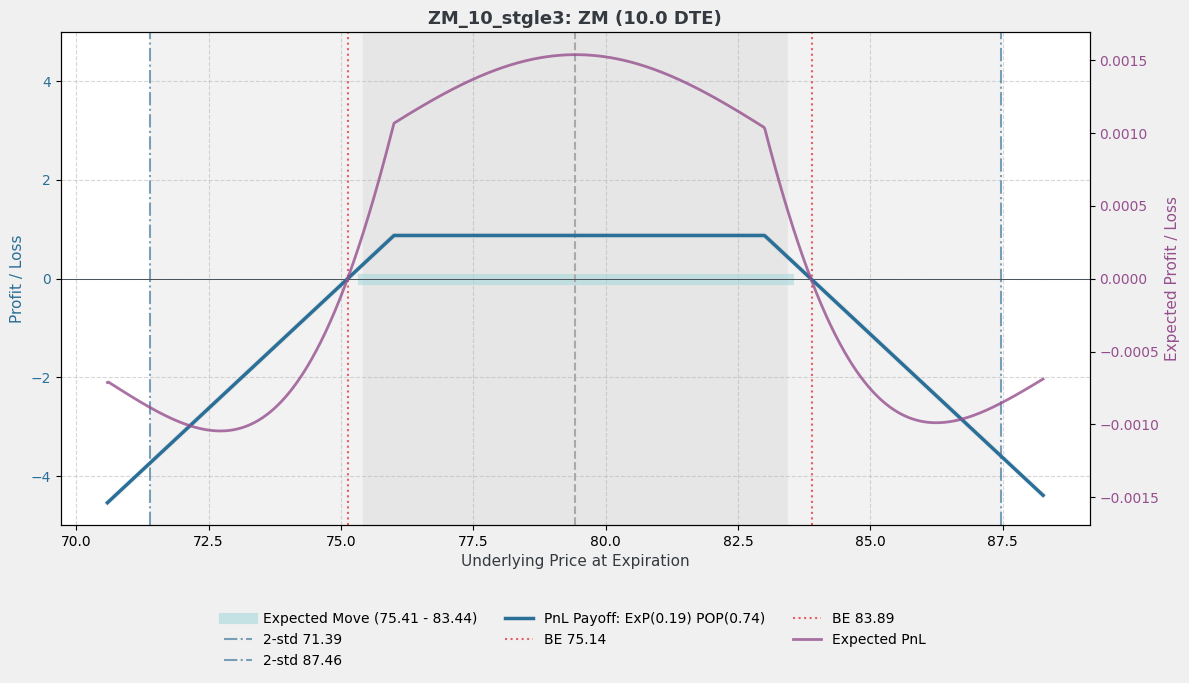


Strategy: TSLA_17_irond3
╒════════════╤══════════════════╤══════╤════════════════════╤═══════════════════╤═════════════════════╤═════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move     │ Volume ratio        │ Volatility ratio    │
├────────────┼──────────────────┼──────┼────────────────────┼───────────────────┼─────────────────────┼─────────────────────┤
│ TSLA       │ 413.295          │ 17.0 │ 0.7686666666666665 │ 69.41563631525331 │ 0.29867176348196356 │ 0.06209805684254199 │
╘════════════╧══════════════════╧══════╧════════════════════╧═══════════════════╧═════════════════════╧═════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪═

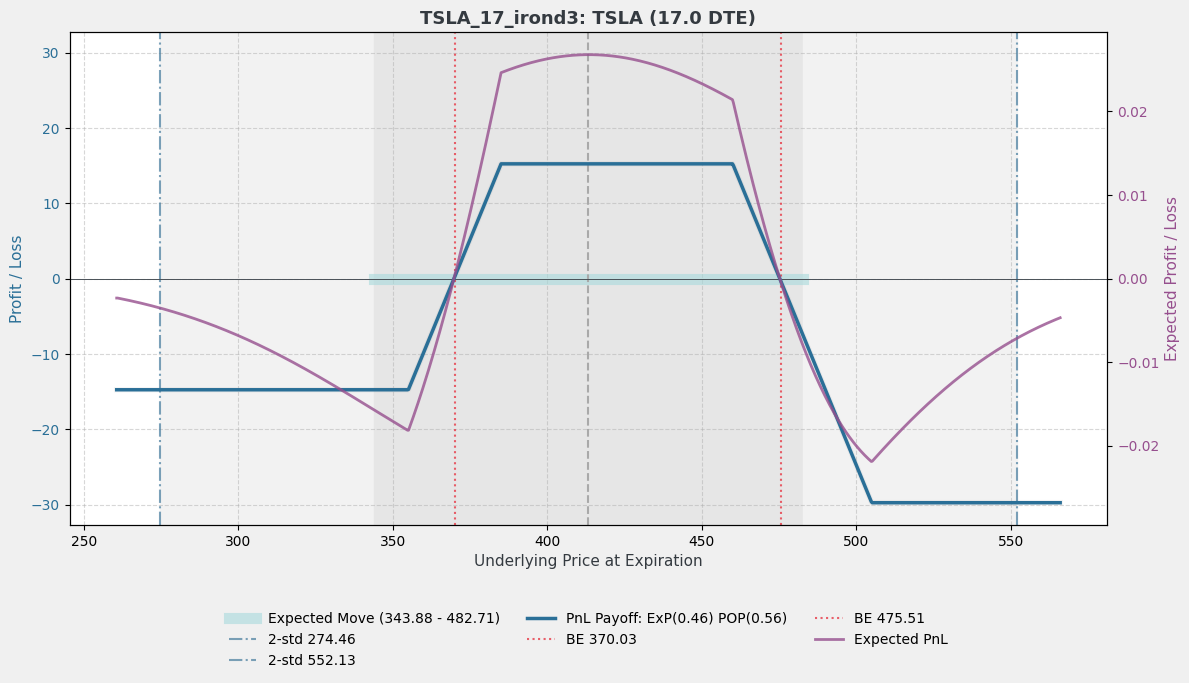


Strategy: AAPL_10_csprd3
╒════════════╤══════════════════╤══════╤════════════════════╤═══════════════════╤════════════════════╤═════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move     │ Volume ratio       │ Volatility ratio    │
├────────────┼──────────────────┼──────┼────────────────────┼───────────────────┼────────────────────┼─────────────────────┤
│ AAPL       │ 235.7            │ 10.0 │ 0.2682608695652174 │ 8.582935149517438 │ 0.4731378369567083 │ -0.0614128505502306 │
╘════════════╧══════════════════╧══════╧════════════════════╧═══════════════════╧════════════════════╧═════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪══════

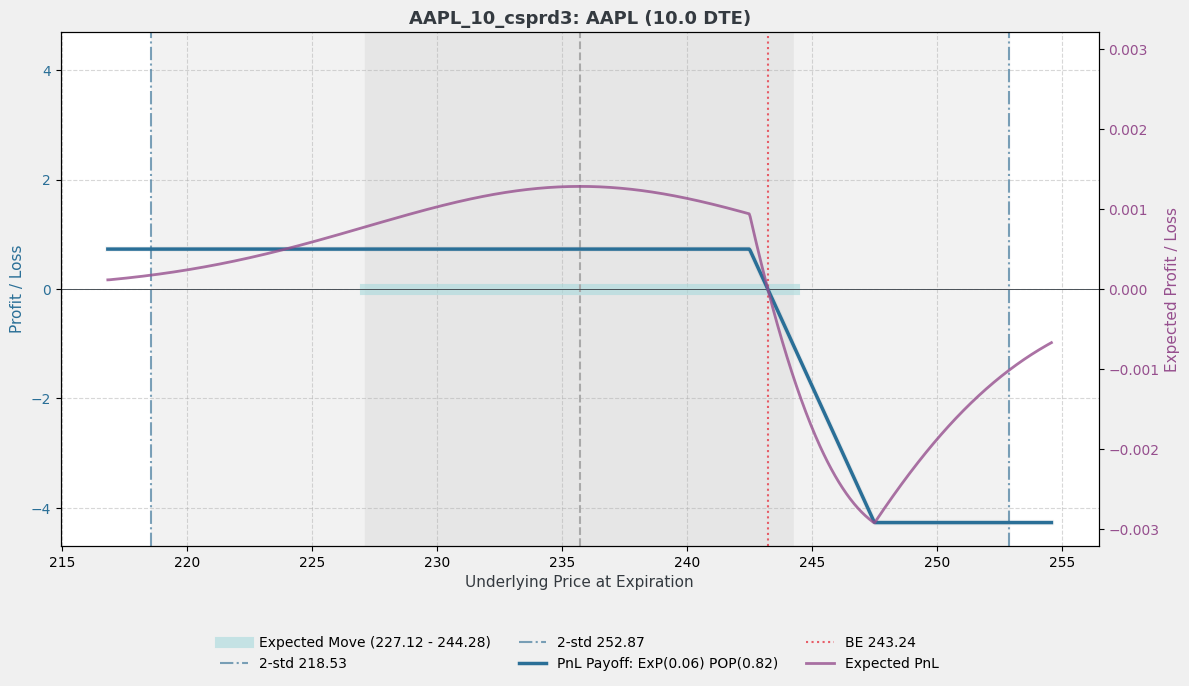


Strategy: NVDA_10_csprd3
╒════════════╤══════════════════╤══════╤════════════╤═══════════════════╤════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility │ Expected Move     │ Volume ratio       │ Volatility ratio     │
├────────────┼──────────────────┼──────┼────────────┼───────────────────┼────────────────────┼──────────────────────┤
│ NVDA       │ 132.785          │ 10.0 │ 0.4450625  │ 9.516789909704466 │ 0.4123140109239154 │ -0.02676563202879001 │
╘════════════╧══════════════════╧══════╧════════════╧═══════════════════╧════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪════════════╪═══════════════════╪════════

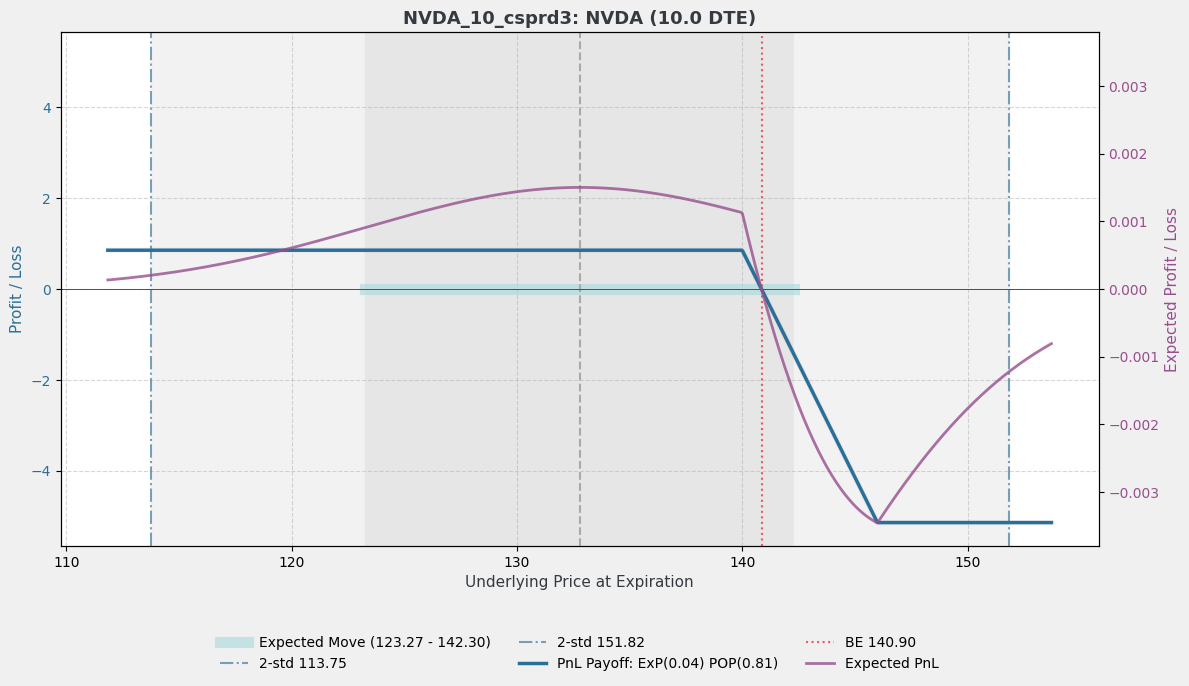


Strategy: AMC_17_stgle3
╒════════════╤══════════════════╤══════╤════════════╤════════════════════╤════════════════════╤════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility │ Expected Move      │ Volume ratio       │ Volatility ratio   │
├────────────┼──────────────────┼──────┼────────────┼────────────────────┼────────────────────┼────────────────────┤
│ AMC        │ 3.455            │ 17.0 │ 0.971      │ 0.8108776790430793 │ 0.9147816938453446 │ 0.3867924528301886 │
╘════════════╧══════════════════╧══════╧════════════╧════════════════════╧════════════════════╧════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪════════════╪═══════════════════╪══════════════

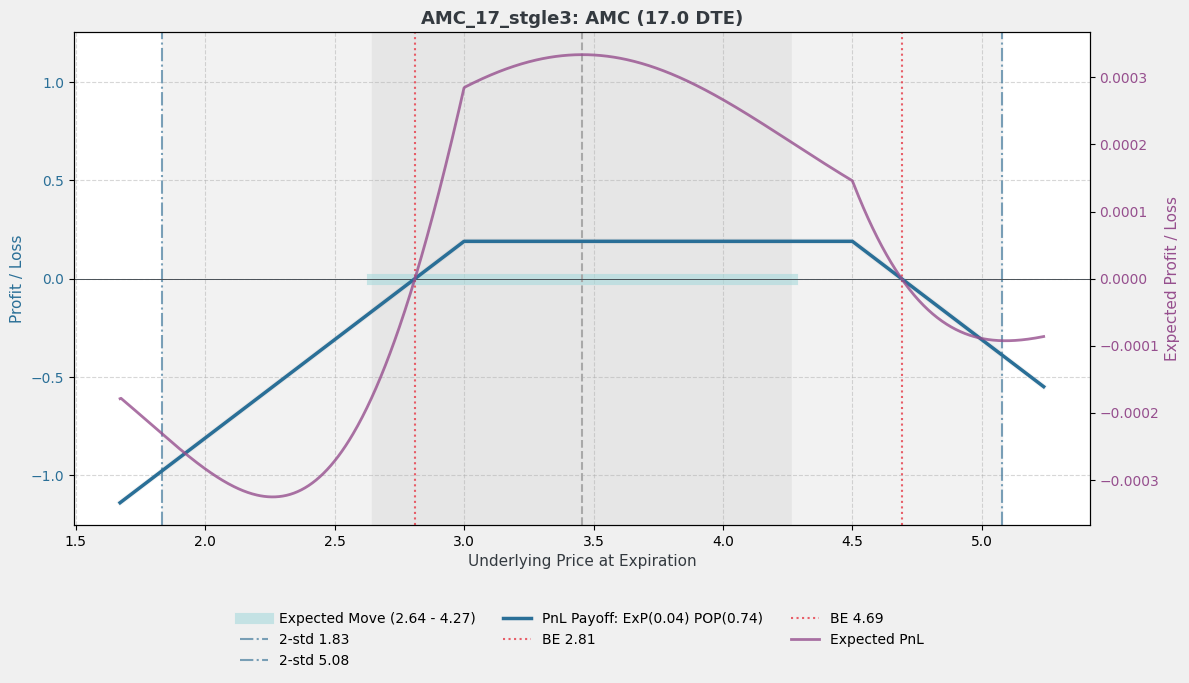


Strategy: BAC_10_csprd3
╒════════════╤══════════════════╤══════╤═════════════════════╤════════════════════╤══════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility          │ Expected Move      │ Volume ratio         │ Volatility ratio     │
├────────────┼──────────────────┼──────┼─────────────────────┼────────────────────┼──────────────────────┼──────────────────────┤
│ BAC        │ 45.555           │ 10.0 │ 0.38223809523809527 │ 2.7107440517546944 │ -0.30441988950276244 │ -0.05490196078431375 │
╘════════════╧══════════════════╧══════╧═════════════════════╧════════════════════╧══════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪══

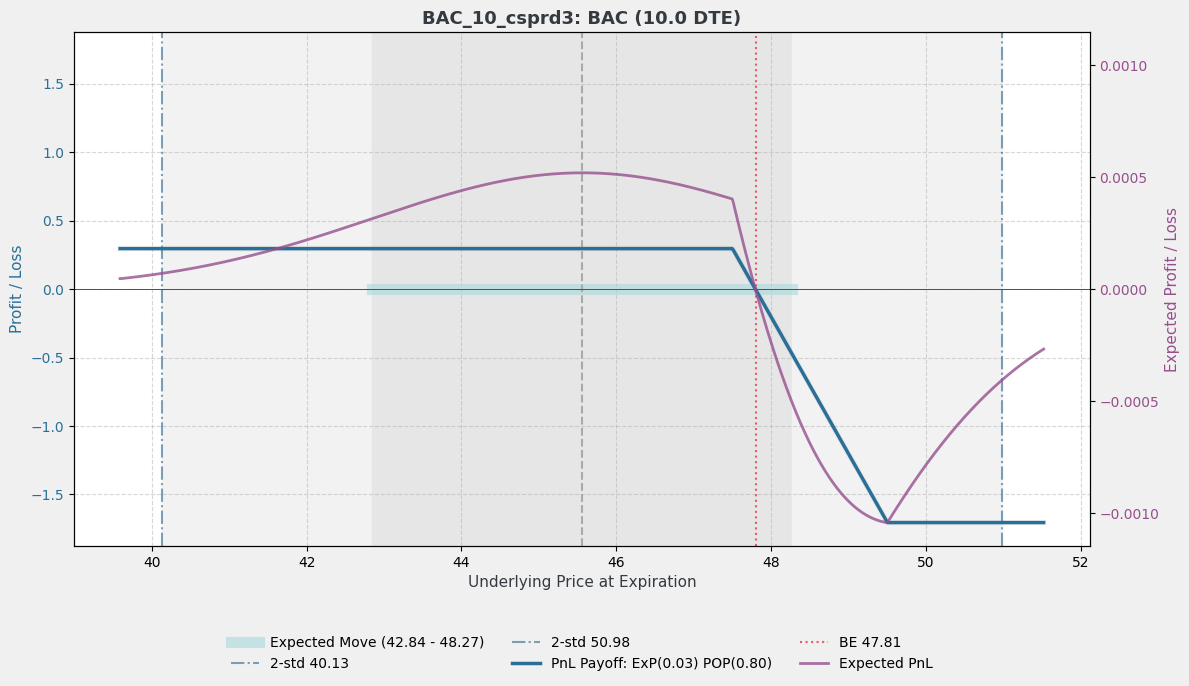


Strategy: META_17_buttr1
╒════════════╤══════════════════╤══════╤═══════════════════╤═══════════════════╤════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility        │ Expected Move     │ Volume ratio       │ Volatility ratio     │
├────────────┼──────────────────┼──────┼───────────────────┼───────────────────┼────────────────────┼──────────────────────┤
│ META       │ 598.155          │ 17.0 │ 0.547939393939394 │ 70.54754936567804 │ 0.5474694589877835 │ 0.005647339436668841 │
╘════════════╧══════════════════╧══════╧═══════════════════╧═══════════════════╧════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪══════

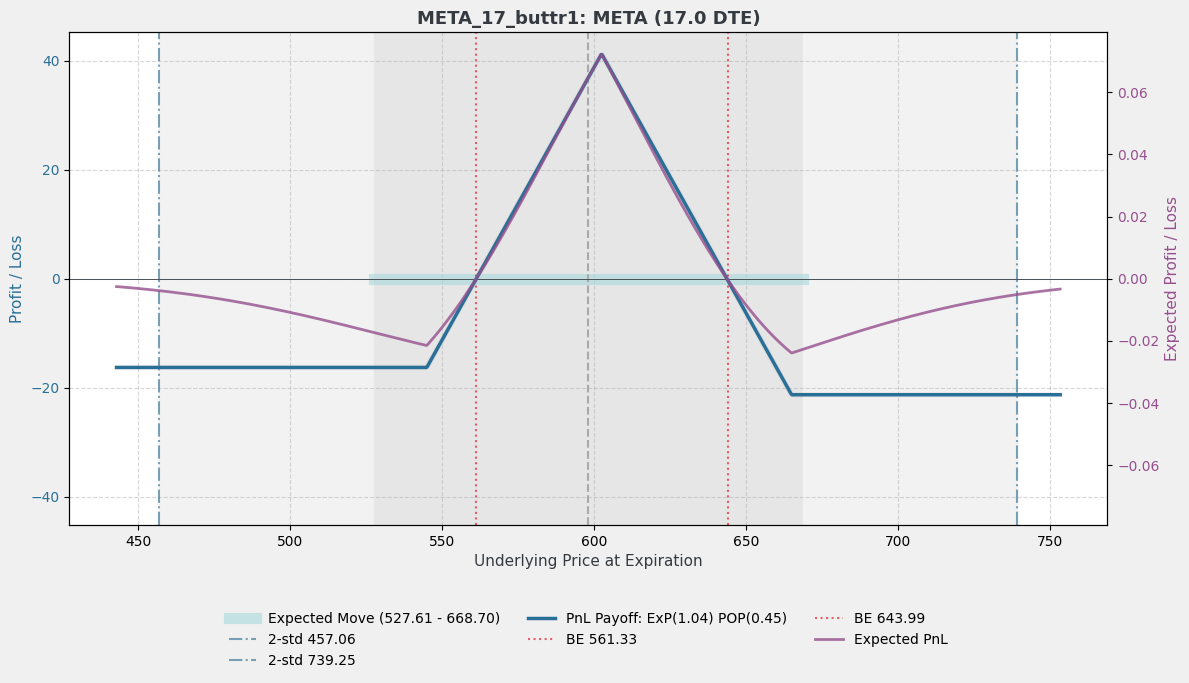


Strategy: AMZN_10_csprd3
╒════════════╤══════════════════╤══════╤═════════════════════╤═══════════════════╤════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility          │ Expected Move     │ Volume ratio       │ Volatility ratio     │
├────────────┼──────────────────┼──────┼─────────────────────┼───────────────────┼────────────────────┼──────────────────────┤
│ AMZN       │ 220.24           │ 10.0 │ 0.30304761904761907 │ 9.970274073546468 │ 0.6784092192972546 │ -0.04616724738675948 │
╘════════════╧══════════════════╧══════╧═════════════════════╧═══════════════════╧════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪═══════

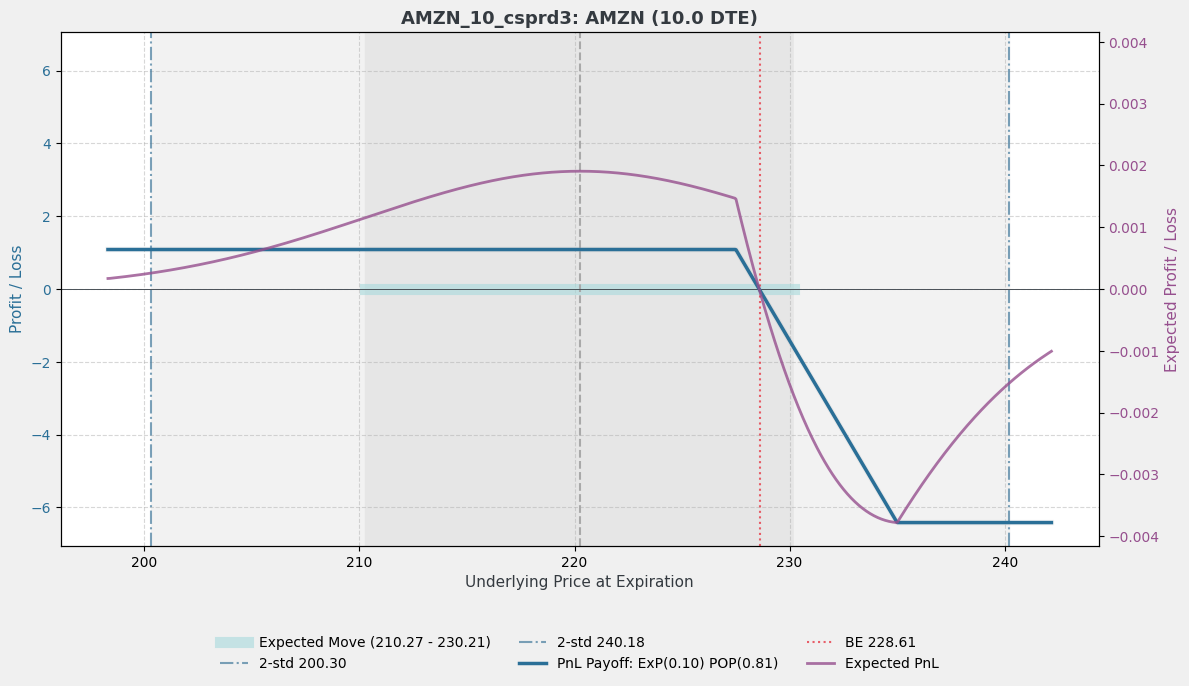


Strategy: AMD_24_buttr1
╒════════════╤══════════════════╤══════╤════════════════════╤═══════════════════╤════════════════════╤═════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move     │ Volume ratio       │ Volatility ratio    │
├────────────┼──────────────────┼──────┼────────────────────┼───────────────────┼────────────────────┼─────────────────────┤
│ AMD        │ 116.005          │ 24.0 │ 0.5467619047619048 │ 16.39032238502139 │ 0.5188115330520393 │ 0.02428848159737751 │
╘════════════╧══════════════════╧══════╧════════════════════╧═══════════════════╧════════════════════╧═════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪═══════

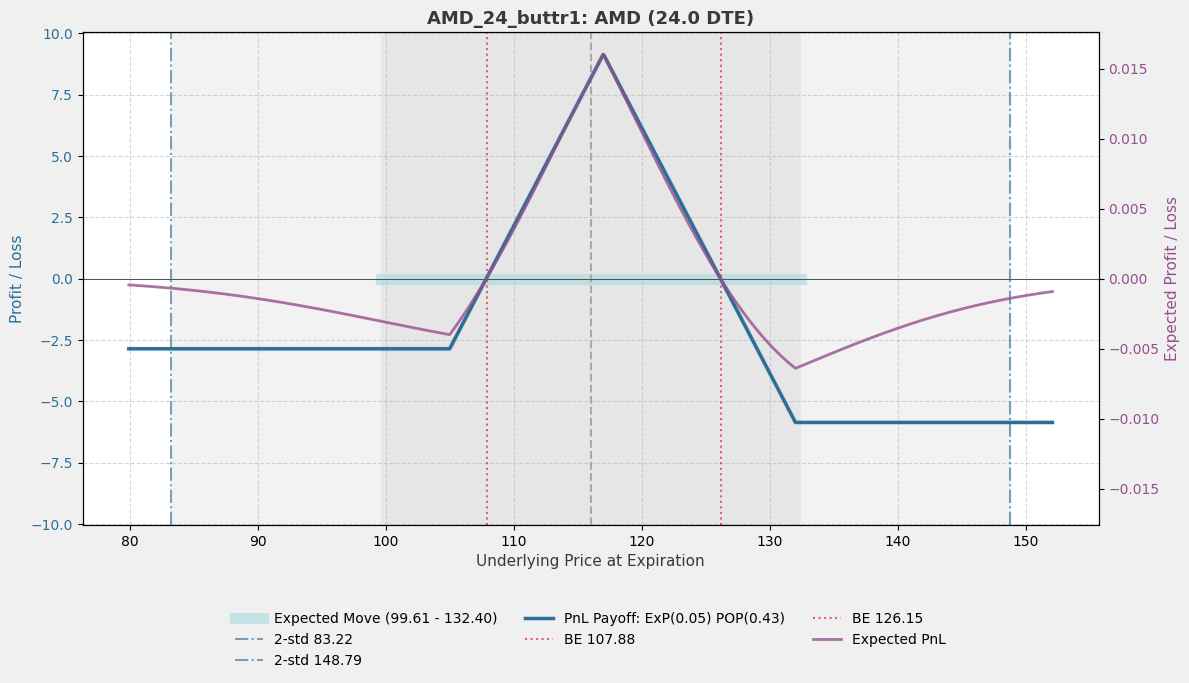


Strategy: SCHW_10_csprd3
╒════════════╤══════════════════╤══════╤════════════════════╤═══════════════════╤══════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move     │ Volume ratio │ Volatility ratio     │
├────────────┼──────────────────┼──────┼────────────────────┼───────────────────┼──────────────┼──────────────────────┤
│ SCHW       │ 71.78            │ 10.0 │ 0.4447058823529412 │ 5.156401799360608 │ -0.775       │ -0.05318761384335169 │
╘════════════╧══════════════════╧══════╧════════════════════╧═══════════════════╧══════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪════════════╪══════════════════

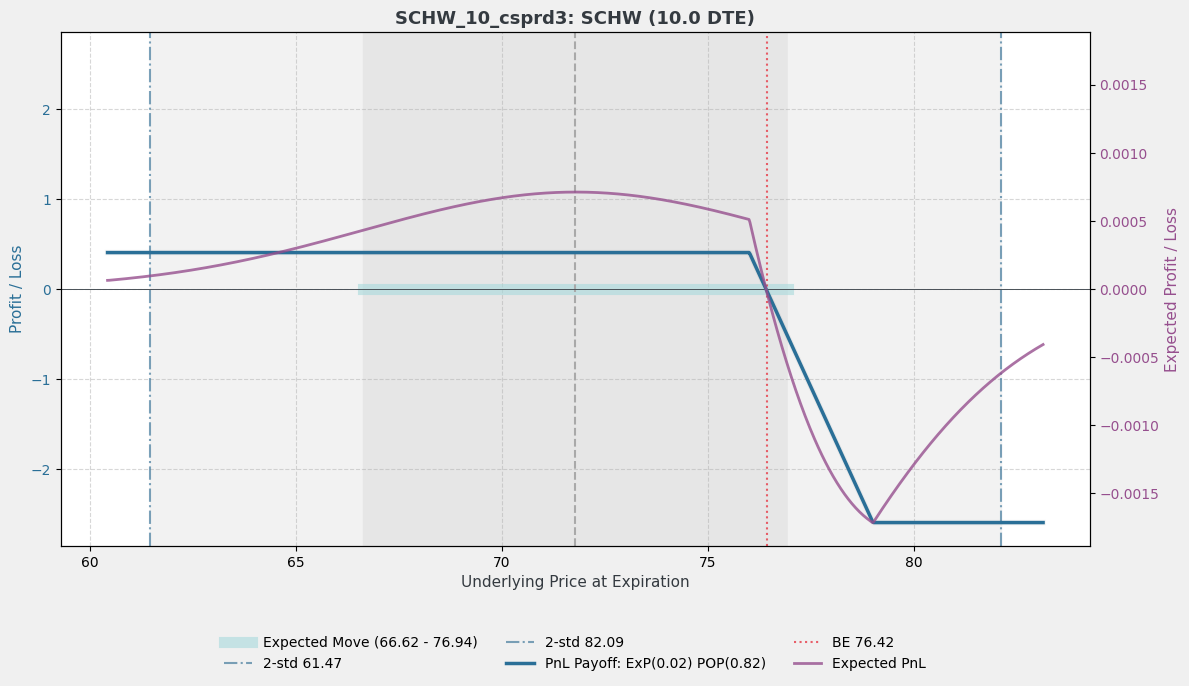


Strategy: MSFT_10_csprd3
╒════════════╤══════════════════╤══════╤═════════════════════╤═══════════════════╤═══════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility          │ Expected Move     │ Volume ratio      │ Volatility ratio     │
├────────────┼──────────────────┼──────┼─────────────────────┼───────────────────┼───────────────────┼──────────────────────┤
│ MSFT       │ 416.875          │ 10.0 │ 0.25367500000000004 │ 14.21433803821782 │ 0.591010105245503 │ -0.06576692373607529 │
╘════════════╧══════════════════╧══════╧═════════════════════╧═══════════════════╧═══════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪═

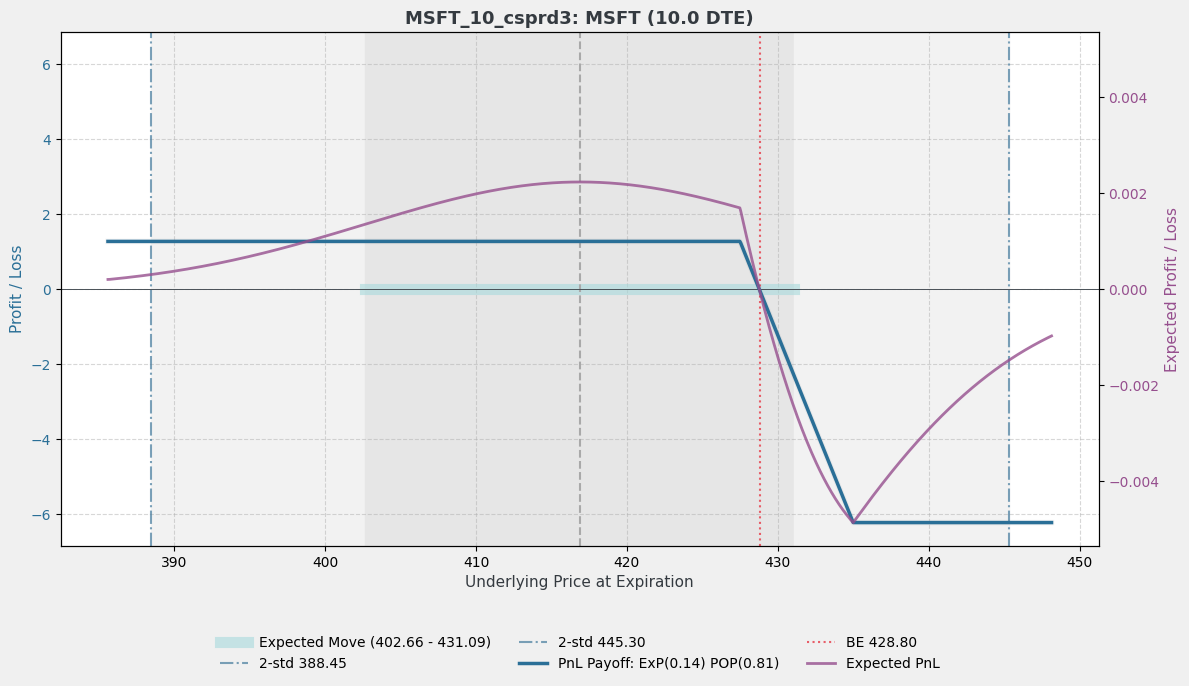


Strategy: MARA_10_buttr1
╒════════════╤══════════════════╤══════╤════════════════════╤════════════════════╤════════════════════╤═════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move      │ Volume ratio       │ Volatility ratio    │
├────────────┼──────────────────┼──────┼────────────────────┼────────────────────┼────────────────────┼─────────────────────┤
│ MARA       │ 17.575           │ 10.0 │ 0.9067222222222223 │ 2.6654030424431974 │ 0.5682971098803928 │ 0.09200293470286125 │
╘════════════╧══════════════════╧══════╧════════════════════╧════════════════════╧════════════════════╧═════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪═

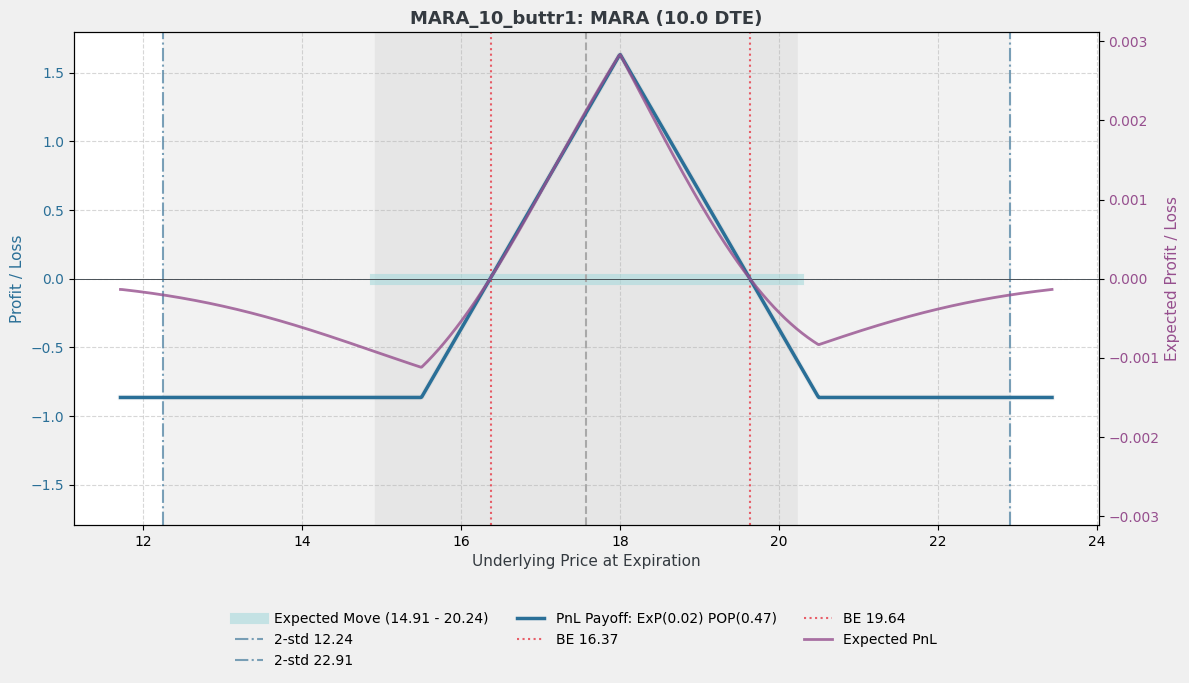


Strategy: GOOGL_17_csprd3
╒════════════╤══════════════════╤══════╤═════════════════════╤════════════════════╤════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility          │ Expected Move      │ Volume ratio       │ Volatility ratio     │
├────────────┼──────────────────┼──────┼─────────────────────┼────────────────────┼────────────────────┼──────────────────────┤
│ GOOGL      │ 190.77           │ 17.0 │ 0.35316666666666663 │ 14.183301481922548 │ 0.7170872188699945 │ -0.03197442046362953 │
╘════════════╧══════════════════╧══════╧═════════════════════╧════════════════════╧════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪═

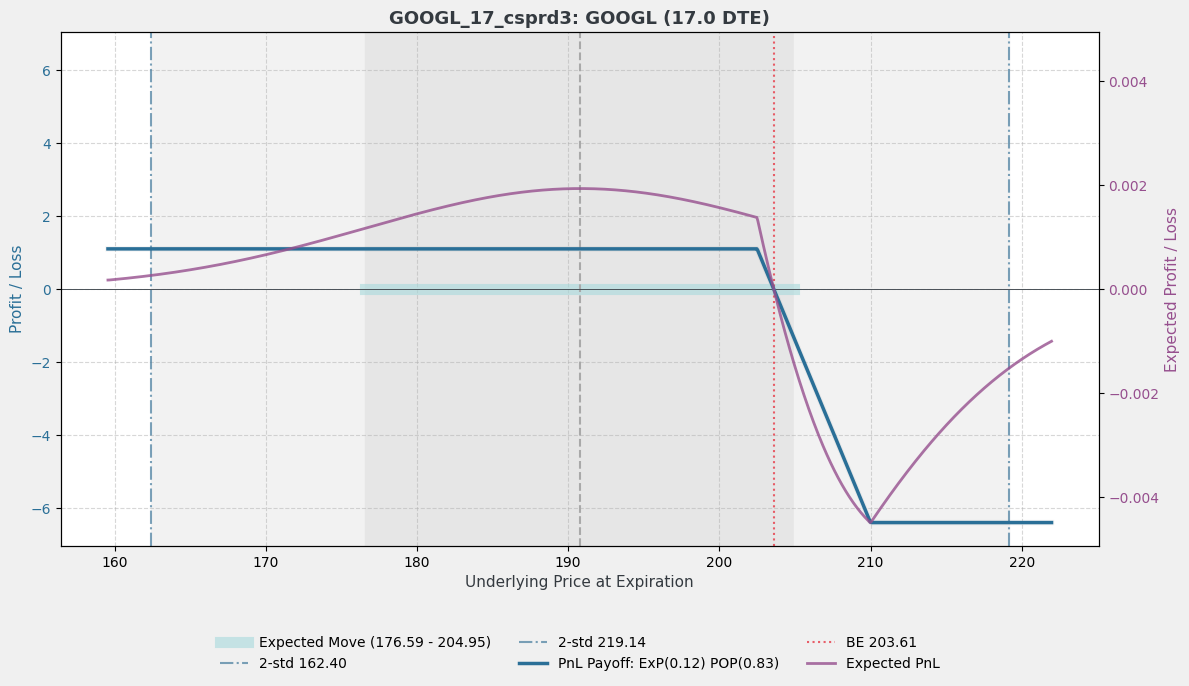


Strategy: CHPT_17_csprd3
╒════════════╤══════════════════╤══════╤════════════╤════════════════════╤════════════════════╤════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility │ Expected Move      │ Volume ratio       │ Volatility ratio   │
├────────────┼──────────────────┼──────┼────────────┼────────────────────┼────────────────────┼────────────────────┤
│ CHPT       │ 1.045            │ 17.0 │ 0.962      │ 0.3529463222047748 │ 0.7386990077177509 │ 0.2408223201174743 │
╘════════════╧══════════════════╧══════╧════════════╧════════════════════╧════════════════════╧════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │       Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪════════════╪═══════════════════╪═════

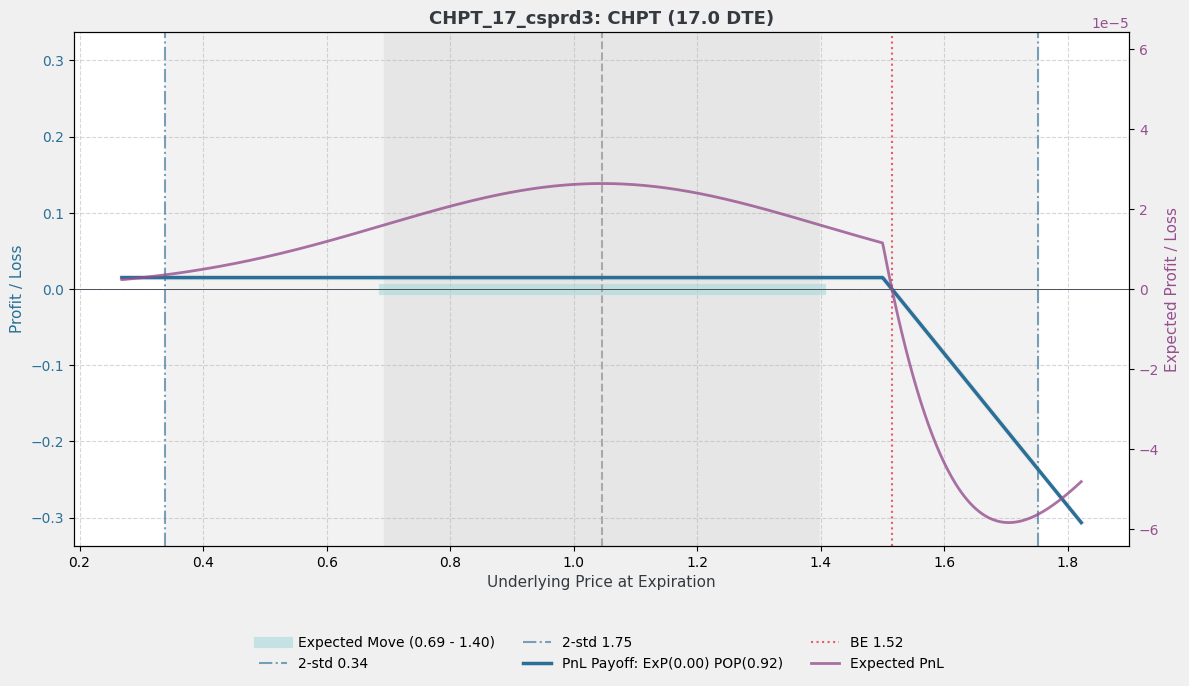


Strategy: C_45_csprd3
╒════════════╤══════════════════╤══════╤════════════════════╤═══════════════════╤═══════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move     │ Volume ratio      │ Volatility ratio     │
├────────────┼──────────────────┼──────┼────────────────────┼───────────────────┼───────────────────┼──────────────────────┤
│ C          │ 73.56            │ 45.0 │ 0.2818333333333334 │ 6.521731691718629 │ 0.803347280334728 │ -0.14174767540152133 │
╘════════════╧══════════════════╧══════╧════════════════════╧═══════════════════╧═══════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪═════════

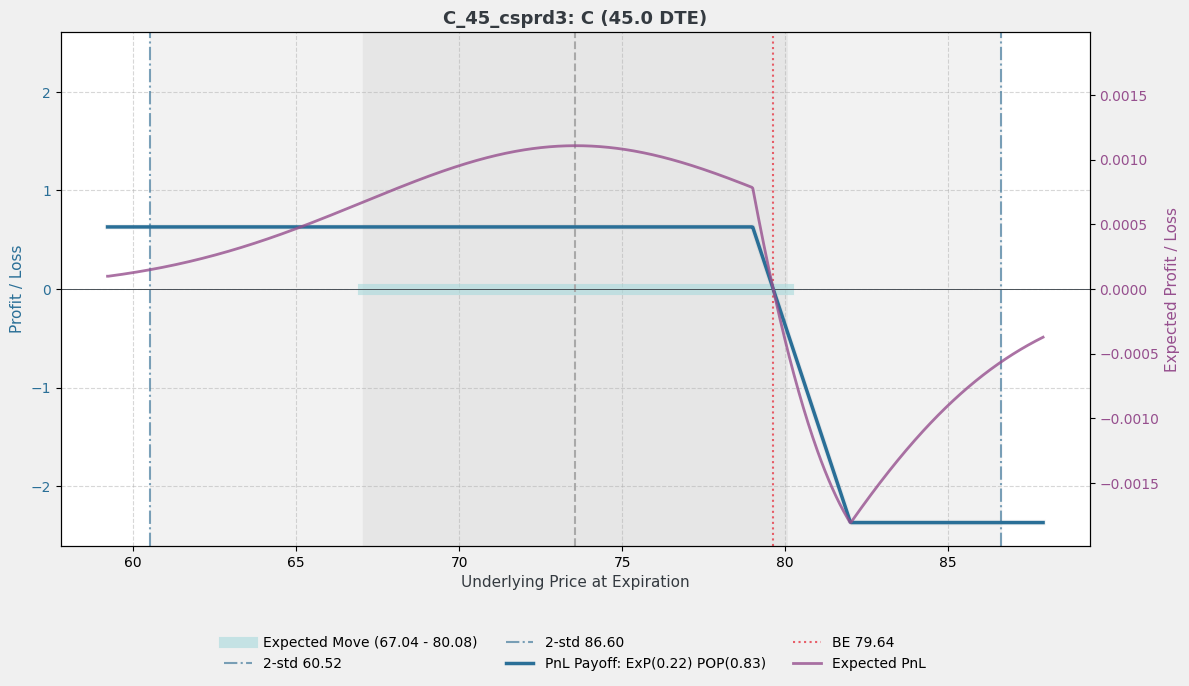


Strategy: COIN_31_irond3
╒════════════╤══════════════════╤══════╤════════════════════╤═══════════════════╤════════════════════╤═════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move     │ Volume ratio       │ Volatility ratio    │
├────────────┼──────────────────┼──────┼────────────────────┼───────────────────┼────────────────────┼─────────────────────┤
│ COIN       │ 259.795          │ 31.0 │ 0.7482692307692308 │ 57.46547210690419 │ 0.4502857142857143 │ 0.07471712836519684 │
╘════════════╧══════════════════╧══════╧════════════════════╧═══════════════════╧════════════════════╧═════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪══════

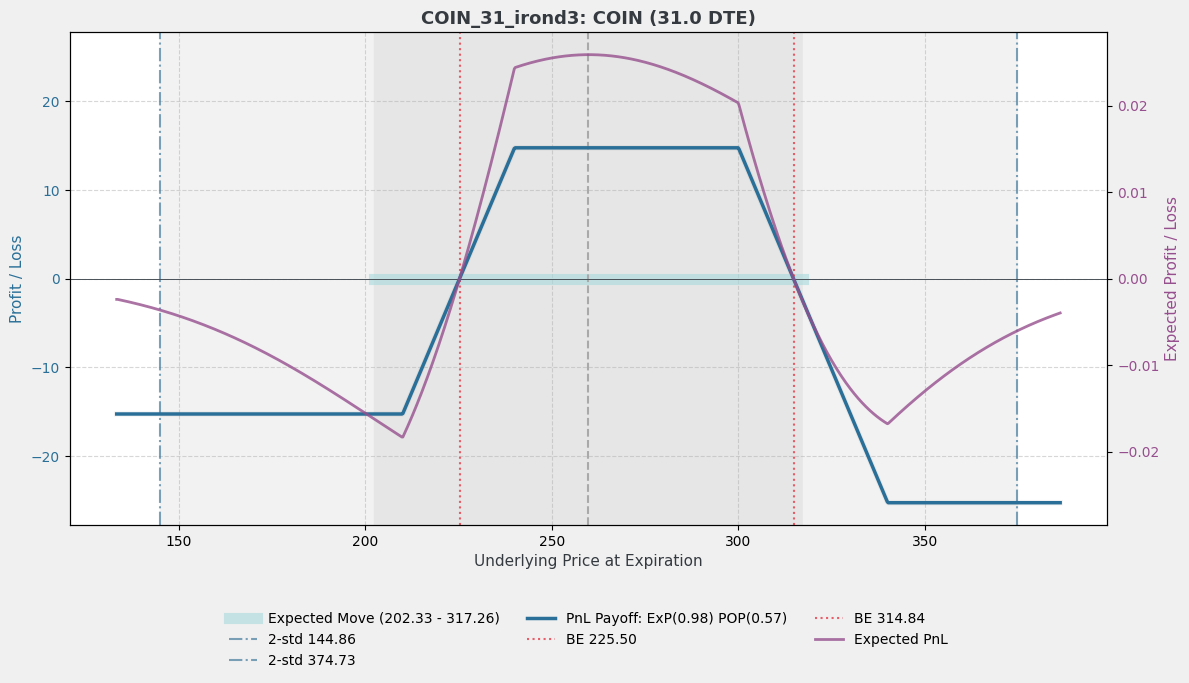


Strategy: GOOG_10_csprd3
╒════════════╤══════════════════╤══════╤════════════════════╤══════════════════╤════════════════════╤═══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move    │ Volume ratio       │ Volatility ratio      │
├────────────┼──────────────────┼──────┼────────────────────┼──────────────────┼────────────────────┼───────────────────────┤
│ GOOG       │ 192.055          │ 10.0 │ 0.3064473684210526 │ 8.74202169145403 │ 0.2838931955211025 │ -0.022281639928698693 │
╘════════════╧══════════════════╧══════╧════════════════════╧══════════════════╧════════════════════╧═══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪═

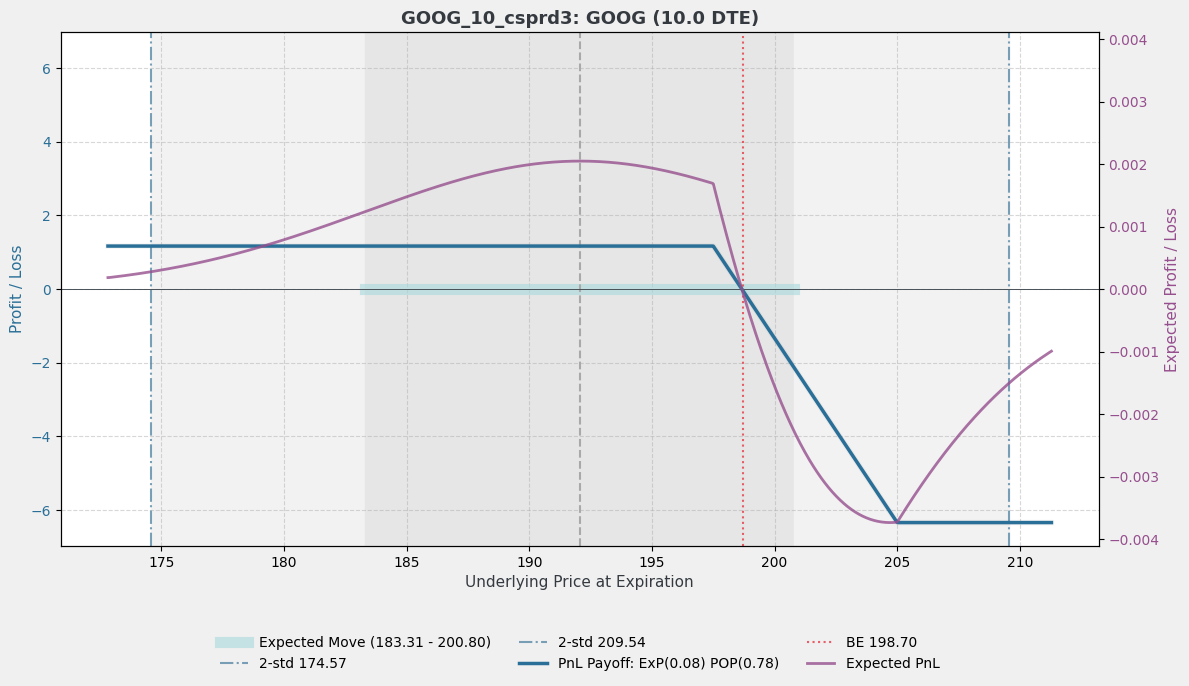


Strategy: WFC_10_buttr1
╒════════════╤══════════════════╤══════╤════════════════════╤════════════════════╤═════════════════════╤════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move      │ Volume ratio        │ Volatility ratio   │
├────────────┼──────────────────┼──────┼────────────────────┼────────────────────┼─────────────────────┼────────────────────┤
│ WFC        │ 70.82            │ 10.0 │ 0.4157352941176471 │ 4.7650782862056404 │ 0.06579764121663567 │ -0.040365209034118 │
╘════════════╧══════════════════╧══════╧════════════════════╧════════════════════╧═════════════════════╧════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪══

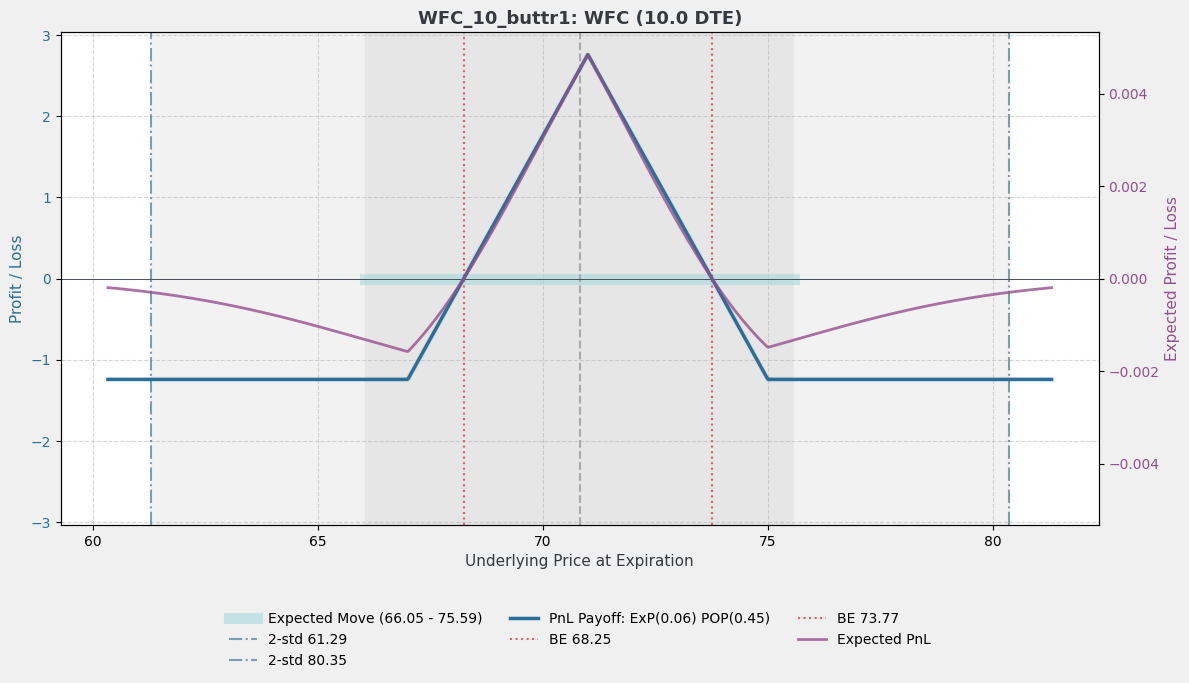


Strategy: INTC_10_buttr1
╒════════════╤══════════════════╤══════╤════════════╤════════════════════╤═══════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility │ Expected Move      │ Volume ratio      │ Volatility ratio     │
├────────────┼──────────────────┼──────┼────────────┼────────────────────┼───────────────────┼──────────────────────┤
│ INTC       │ 19.185           │ 10.0 │ 0.506      │ 1.5798230877972246 │ 0.539297475301866 │ 0.003978779840849045 │
╘════════════╧══════════════════╧══════╧════════════╧════════════════════╧═══════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪════════════╪═══════════════════╪════════

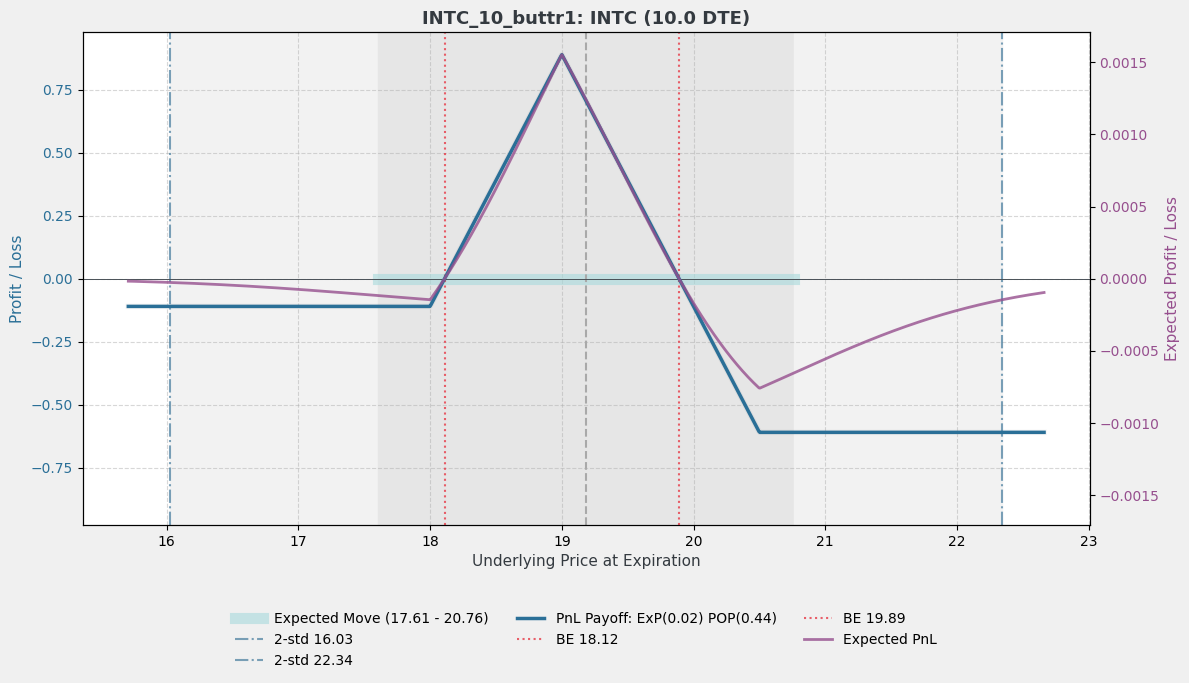


Strategy: SPY_7_csprd3
╒════════════╤══════════════════╤═════╤═════════════════════╤════════════════════╤═════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE │ Volatility          │ Expected Move      │ Volume ratio        │ Volatility ratio     │
├────────────┼──────────────────┼─────┼─────────────────────┼────────────────────┼─────────────────────┼──────────────────────┤
│ SPY        │ 583.29           │ 7.0 │ 0.19610795454545452 │ 11.429929680646786 │ 0.11216644896435901 │ -0.14918869127754553 │
╘════════════╧══════════════════╧═════╧═════════════════════╧════════════════════╧═════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days             │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════

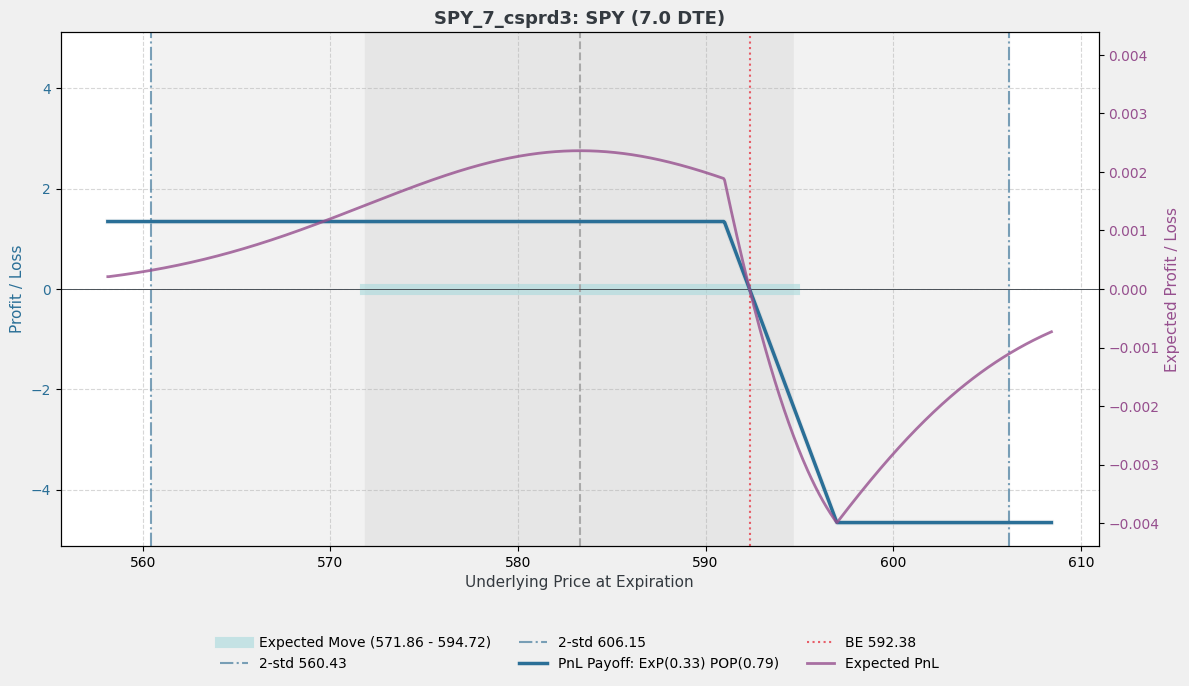


Strategy: QQQ_7_csprd3
╒════════════╤══════════════════╤═════╤═══════════════════╤═══════════════════╤═════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE │ Volatility        │ Expected Move     │ Volume ratio        │ Volatility ratio     │
├────────────┼──────────────────┼─────┼───────────────────┼───────────────────┼─────────────────────┼──────────────────────┤
│ QQQ        │ 507.58           │ 7.0 │ 0.253489898989899 │ 13.14463998162251 │ 0.14479289220658043 │ -0.12715477293790534 │
╘════════════╧══════════════════╧═════╧═══════════════════╧═══════════════════╧═════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days             │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪══════════

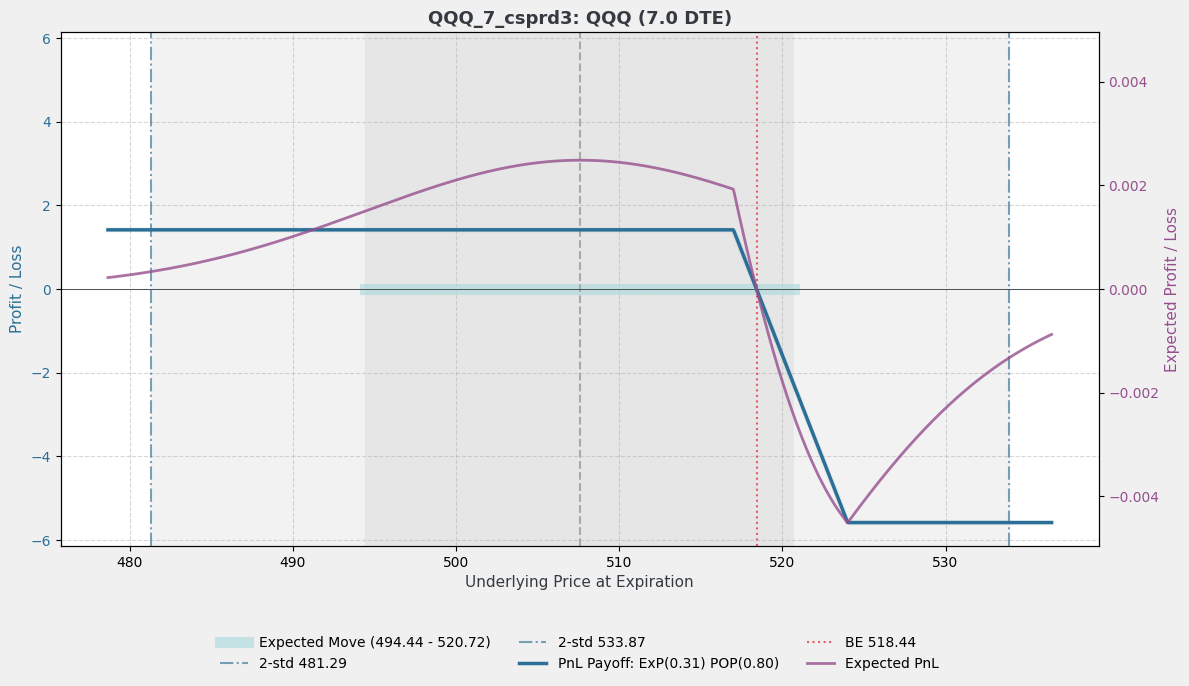


Strategy: IWM_7_csprd3
╒════════════╤══════════════════╤═════╤═════════════════════╤═══════════════════╤════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE │ Volatility          │ Expected Move     │ Volume ratio       │ Volatility ratio     │
├────────────┼──────────────────┼─────┼─────────────────────┼───────────────────┼────────────────────┼──────────────────────┤
│ IWM        │ 219.91           │ 7.0 │ 0.27854716981132077 │ 6.958790641415621 │ 0.5509037255625231 │ -0.08609887724086618 │
╘════════════╧══════════════════╧═════╧═════════════════════╧═══════════════════╧════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days             │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪═════

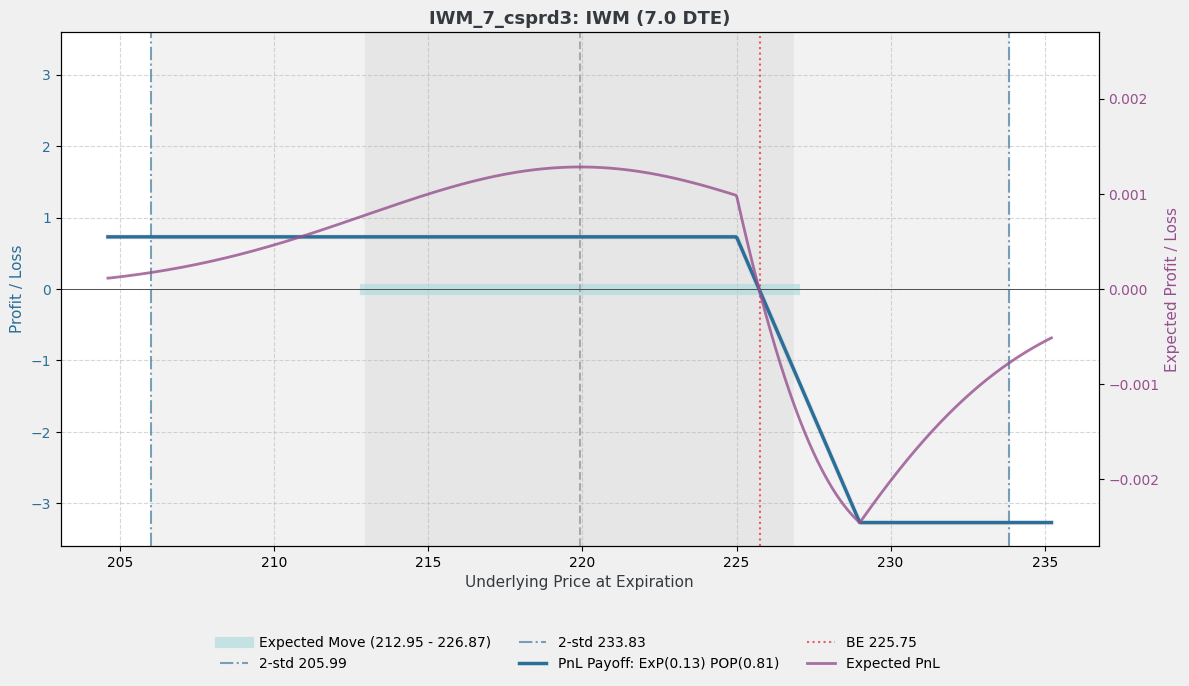


Strategy: TQQQ_10_csprd3
╒════════════╤══════════════════╤══════╤════════════════════╤══════════════════╤════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move    │ Volume ratio       │ Volatility ratio     │
├────────────┼──────────────────┼──────┼────────────────────┼──────────────────┼────────────────────┼──────────────────────┤
│ TQQQ       │ 76.795           │ 10.0 │ 0.6238529411764705 │ 7.15004934921212 │ 0.6708461446312343 │ -0.15657464788732411 │
╘════════════╧══════════════════╧══════╧════════════════════╧══════════════════╧════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪══════

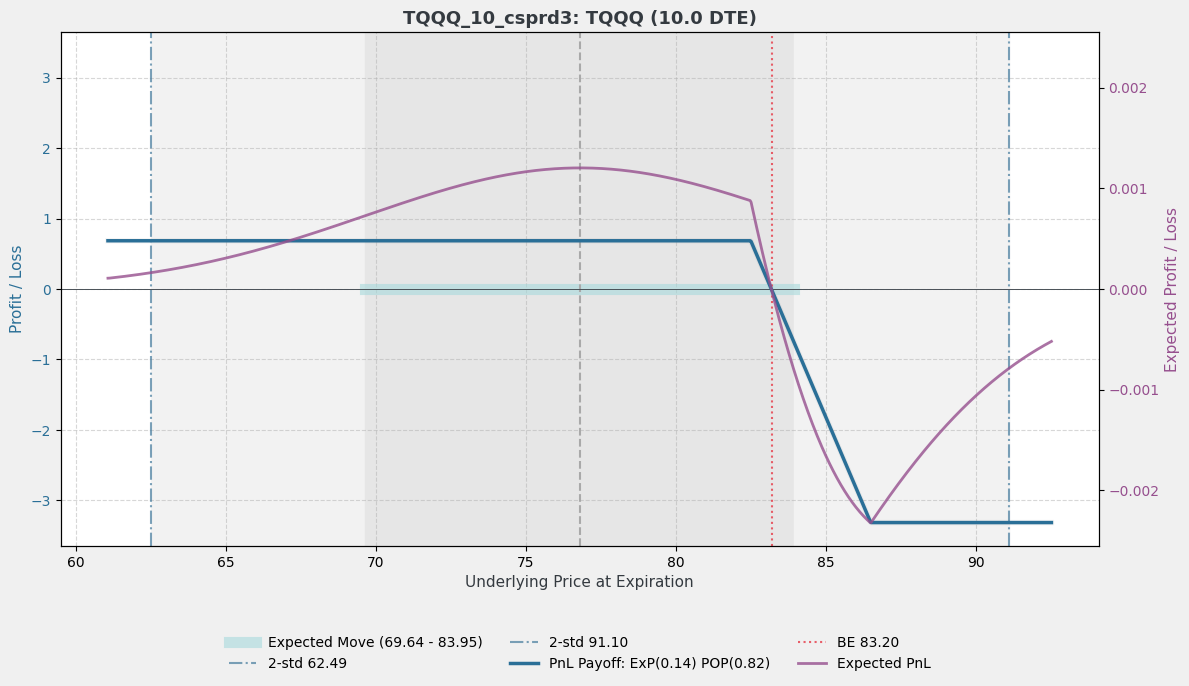


Strategy: EEM_45_buttr1
╒════════════╤══════════════════╤══════╤═════════════════════╤════════════════════╤══════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility          │ Expected Move      │ Volume ratio │ Volatility ratio     │
├────────────┼──────────────────┼──────┼─────────────────────┼────────────────────┼──────────────┼──────────────────────┤
│ EEM        │ 41.275           │ 45.0 │ 0.17289473684210524 │ 2.4564990987395667 │ 0.6          │ -0.13851717902350813 │
╘════════════╧══════════════════╧══════╧═════════════════════╧════════════════════╧══════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪════════════╪═════════

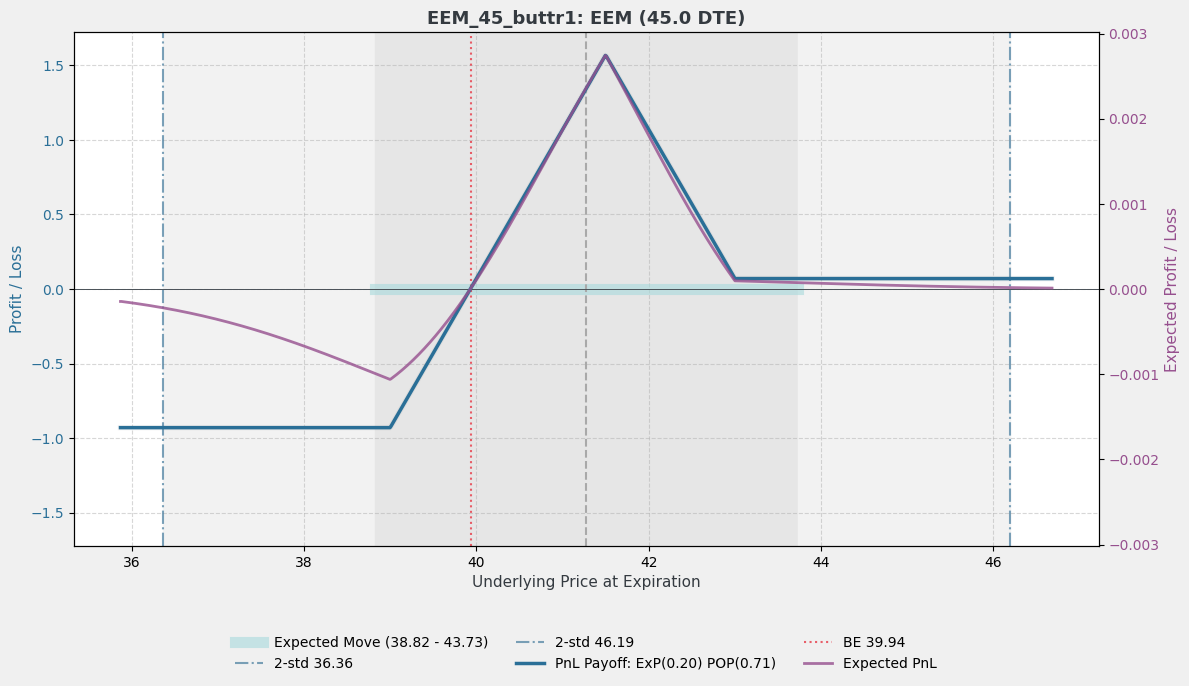


Strategy: UVXY_31_irond3
╒════════════╤══════════════════╤══════╤════════════╤═══════════════════╤════════════════════╤════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility │ Expected Move     │ Volume ratio       │ Volatility ratio   │
├────────────┼──────────────────┼──────┼────────────┼───────────────────┼────────────────────┼────────────────────┤
│ UVXY       │ 21.3             │ 31.0 │ 1.124      │ 8.172122753886892 │ 0.7338809034907597 │ 0.3909634175886296 │
╘════════════╧══════════════════╧══════╧════════════╧═══════════════════╧════════════════════╧════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪════════════╪═══════════════════╪══════════════╪═══

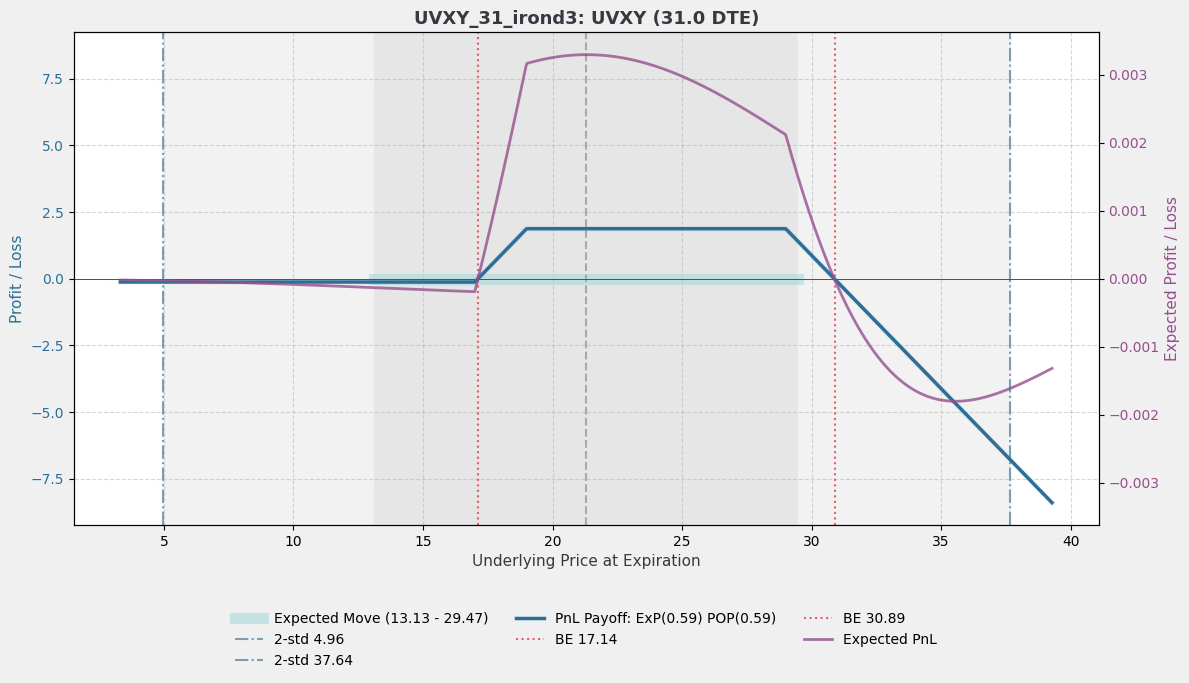


Strategy: KRE_10_buttr1
╒════════════╤══════════════════╤══════╤════════════════════╤═══════════════════╤════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move     │ Volume ratio       │ Volatility ratio     │
├────────────┼──────────────────┼──────┼────────────────────┼───────────────────┼────────────────────┼──────────────────────┤
│ KRE        │ 60.31            │ 10.0 │ 0.3519074074074074 │ 3.424025704314364 │ 0.5964157706093189 │ 0.005059631369714435 │
╘════════════╧══════════════════╧══════╧════════════════════╧═══════════════════╧════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪══

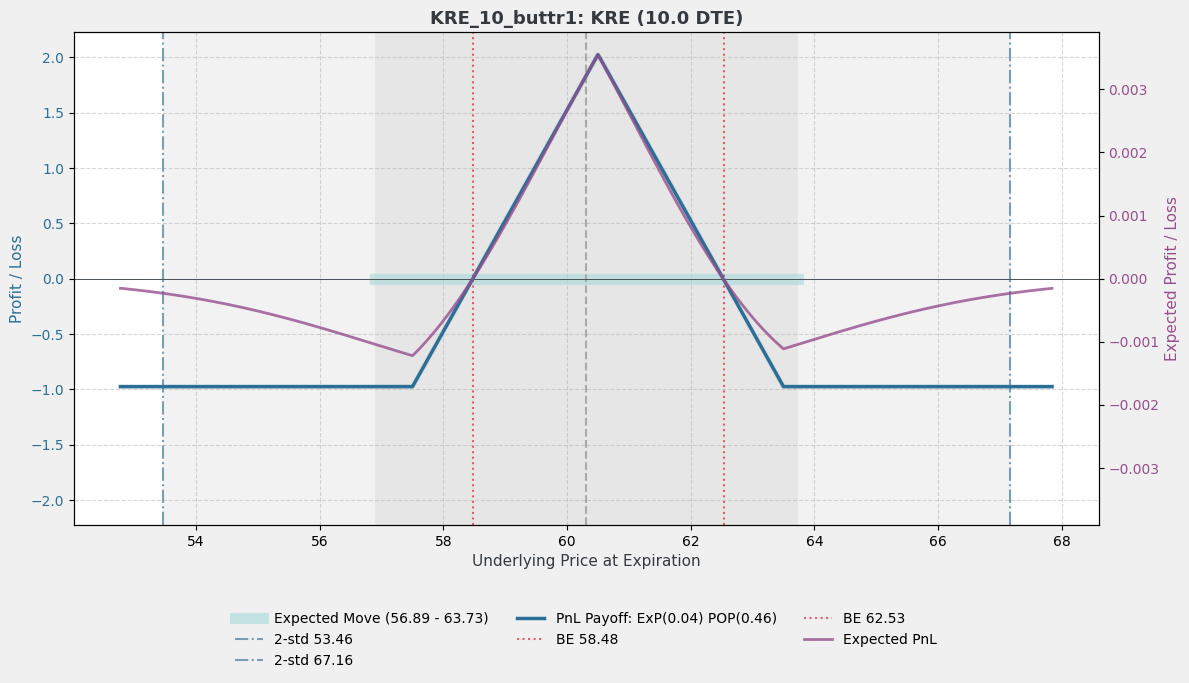


Strategy: GDX_31_buttr1
╒════════════╤══════════════════╤══════╤═════════════════════╤═══════════════════╤════════════════════╤═════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility          │ Expected Move     │ Volume ratio       │ Volatility ratio    │
├────────────┼──────────────────┼──────┼─────────────────────┼───────────────────┼────────────────────┼─────────────────────┤
│ GDX        │ 36.275           │ 31.0 │ 0.32299999999999995 │ 3.396135207638714 │ 0.3782894736842105 │ 0.07425555974368658 │
╘════════════╧══════════════════╧══════╧═════════════════════╧═══════════════════╧════════════════════╧═════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪══

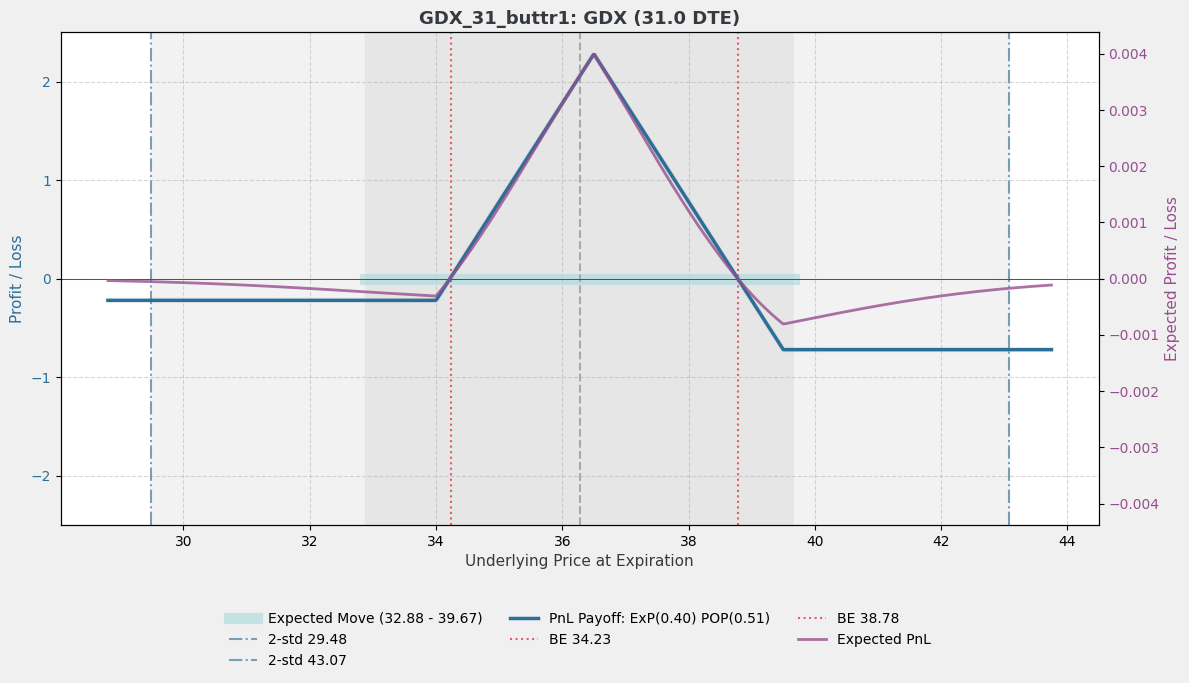


Strategy: GLD_15_buttr1
╒════════════╤══════════════════╤══════╤═════════════════════╤═══════════════════╤══════════════╤═════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility          │ Expected Move     │ Volume ratio │ Volatility ratio    │
├────────────┼──────────────────┼──────┼─────────────────────┼───────────────────┼──────────────┼─────────────────────┤
│ GLD        │ 246.55           │ 15.0 │ 0.14718333333333336 │ 6.722433093501269 │ 1.0          │ 0.07638279192273922 │
╘════════════╧══════════════════╧══════╧═════════════════════╧═══════════════════╧══════════════╧═════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪════════════╪═══════════════════

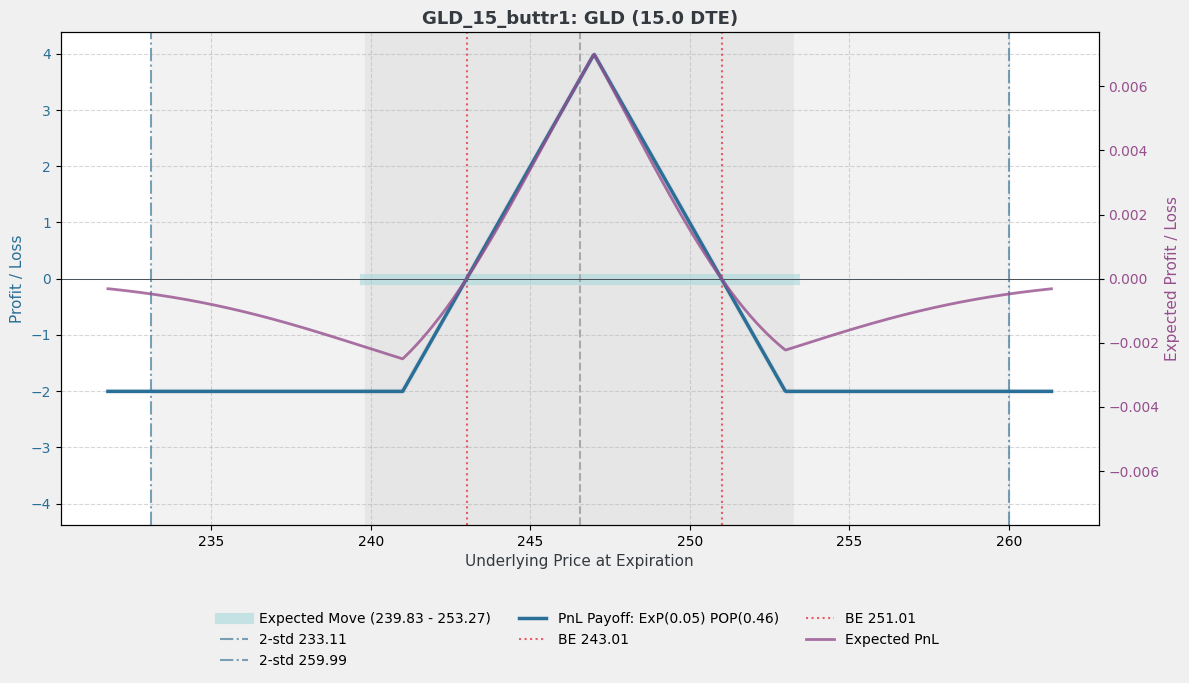


Strategy: XLE_17_csprd3
╒════════════╤══════════════════╤══════╤═════════════════════╤════════════════════╤══════════════════════╤═══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility          │ Expected Move      │ Volume ratio         │ Volatility ratio      │
├────────────┼──────────────────┼──────┼─────────────────────┼────────────────────┼──────────────────────┼───────────────────────┤
│ XLE        │ 90.36            │ 17.0 │ 0.22629729729729728 │ 3.9781798942674746 │ -0.07931726907630521 │ 0.0006778741865510751 │
╘════════════╧══════════════════╧══════╧═════════════════════╧════════════════════╧══════════════════════╧═══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═════════════════════

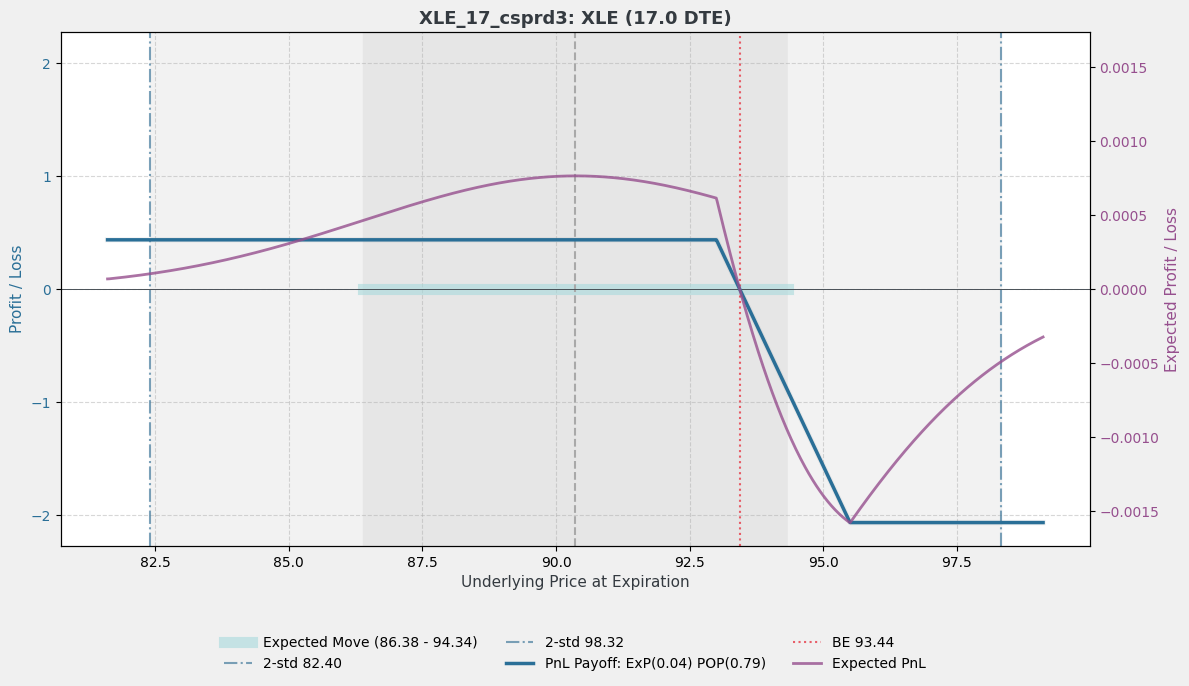


Strategy: SLV_8_stgle3
╒════════════╤══════════════════╤═════╤════════════════════╤════════════════════╤═════════════════════╤════════════════════╕
│ Underlying │ Underlying Price │ DTE │ Volatility         │ Expected Move      │ Volume ratio        │ Volatility ratio   │
├────────────┼──────────────────┼─────┼────────────────────┼────────────────────┼─────────────────────┼────────────────────┤
│ SLV        │ 27.265           │ 8.0 │ 0.2918214285714286 │ 0.9808674819354326 │ -0.1893837910247823 │ 0.0677290836653387 │
╘════════════╧══════════════════╧═════╧════════════════════╧════════════════════╧═════════════════════╧════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days             │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪══════════

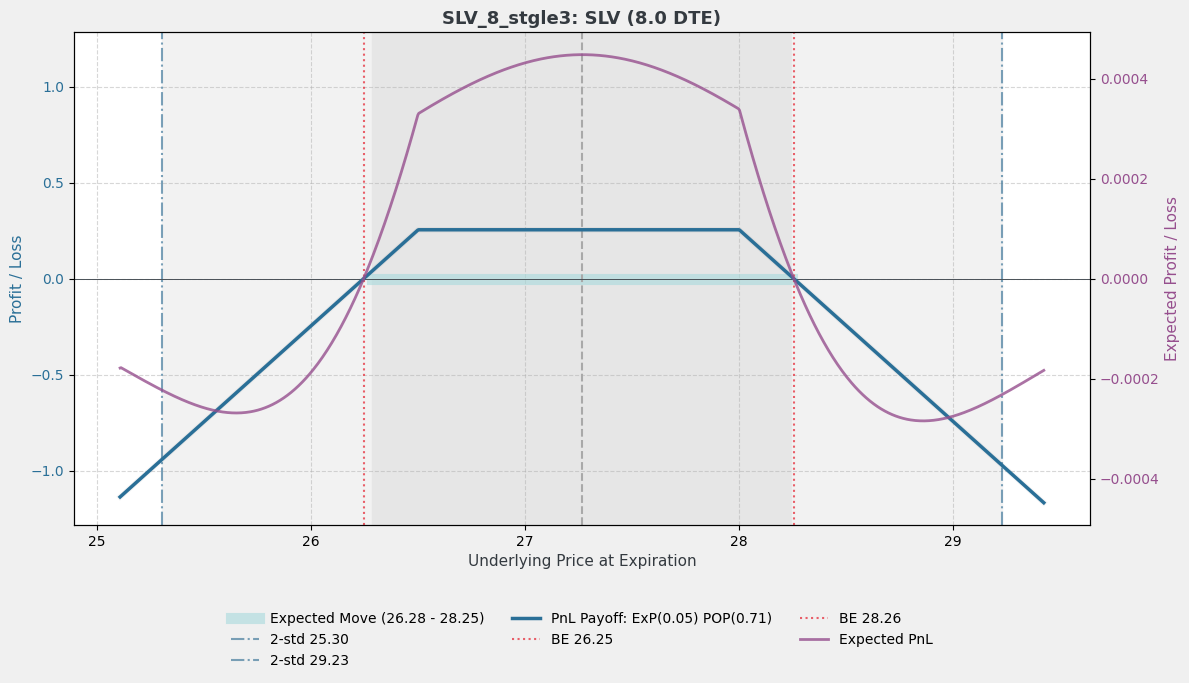


Strategy: SQQQ_10_irond3
╒════════════╤══════════════════╤══════╤════════════════════╤════════════════════╤════════════════════╤═════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move      │ Volume ratio       │ Volatility ratio    │
├────────────┼──────────────────┼──────┼────────────────────┼────────────────────┼────────────────────┼─────────────────────┤
│ SQQQ       │ 31.895           │ 10.0 │ 0.6429333333333334 │ 3.4566203415325516 │ 0.8085806641198943 │ 0.17425707754527853 │
╘════════════╧══════════════════╧══════╧════════════════════╧════════════════════╧════════════════════╧═════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪═

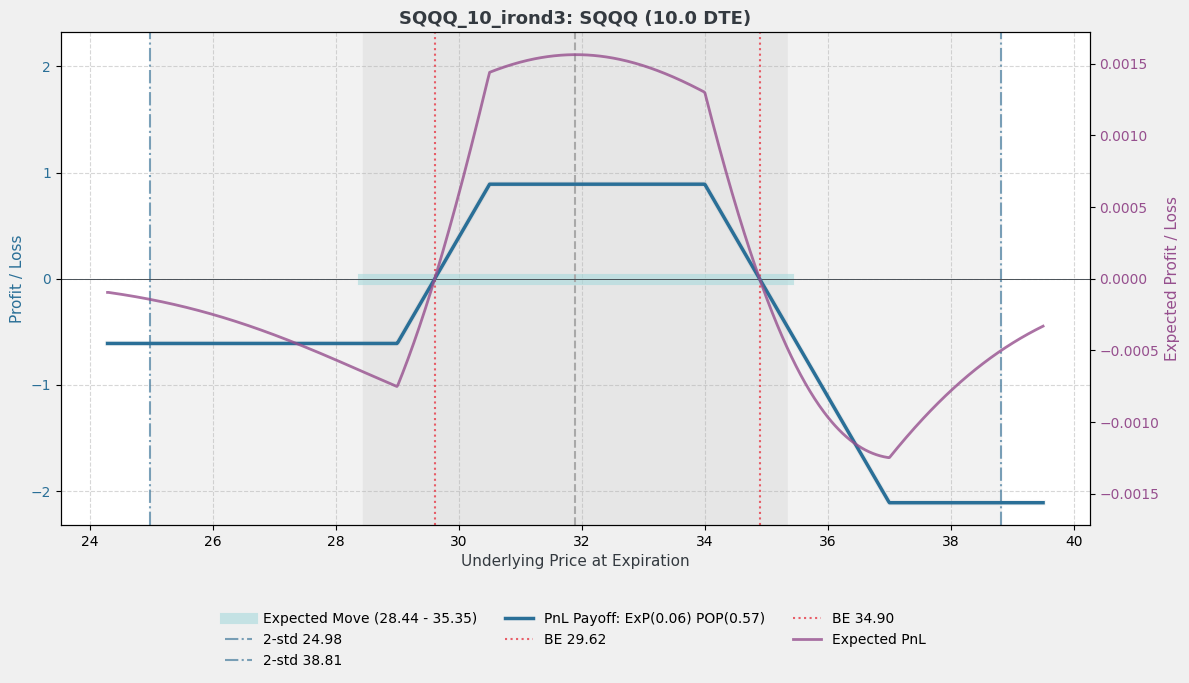


Strategy: TLT_13_csprd3
╒════════════╤══════════════════╤══════╤═════════════════════╤════════════════════╤════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility          │ Expected Move      │ Volume ratio       │ Volatility ratio     │
├────────────┼──────────────────┼──────┼─────────────────────┼────────────────────┼────────────────────┼──────────────────────┤
│ TLT        │ 85.125           │ 13.0 │ 0.19158064516129034 │ 2.6105723518673702 │ 0.6320422535211268 │ 0.054470709146968166 │
╘════════════╧══════════════════╧══════╧═════════════════════╧════════════════════╧════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪═══

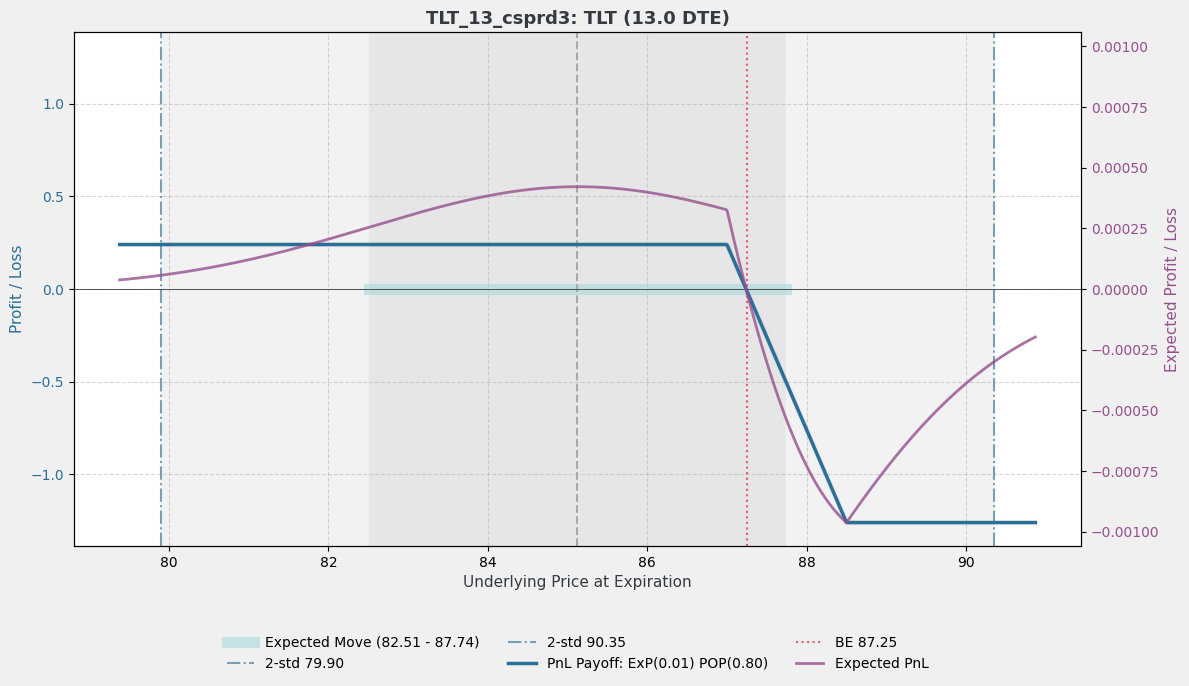


Strategy: SOXL_10_csprd3
╒════════════╤══════════════════╤══════╤════════════════════╤═══════════════════╤════════════════════╤═════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move     │ Volume ratio       │ Volatility ratio    │
├────────────┼──────────────────┼──────┼────────────────────┼───────────────────┼────────────────────┼─────────────────────┤
│ SOXL       │ 28.135           │ 10.0 │ 0.9558571428571427 │ 4.307667960028111 │ 0.5214111922141119 │ -0.0899397260273972 │
╘════════════╧══════════════════╧══════╧════════════════════╧═══════════════════╧════════════════════╧═════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪══════

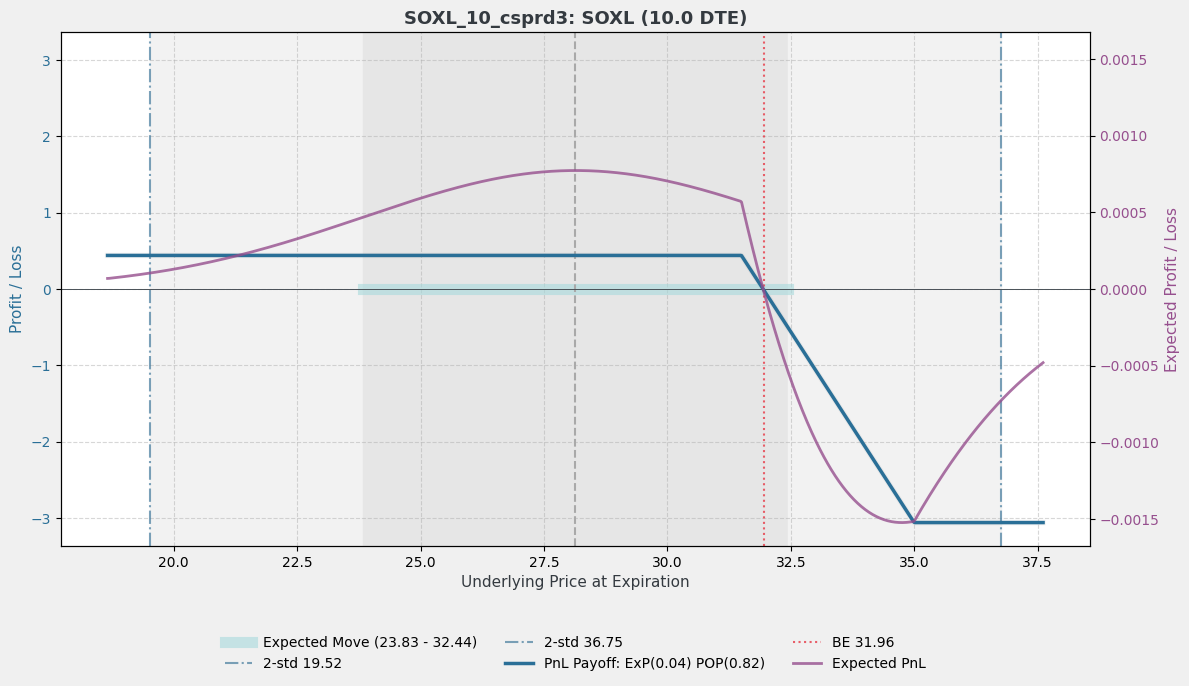


Strategy: ARKK_10_irond3
╒════════════╤══════════════════╤══════╤════════════════════╤═══════════════════╤═════════════════════╤═══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move     │ Volume ratio        │ Volatility ratio      │
├────────────┼──────────────────┼──────┼────────────────────┼───────────────────┼─────────────────────┼───────────────────────┤
│ ARKK       │ 57.525           │ 10.0 │ 0.4415185185185185 │ 4.177604522097444 │ -0.9404043611728591 │ -0.027209186220669035 │
╘════════════╧══════════════════╧══════╧════════════════════╧═══════════════════╧═════════════════════╧═══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══

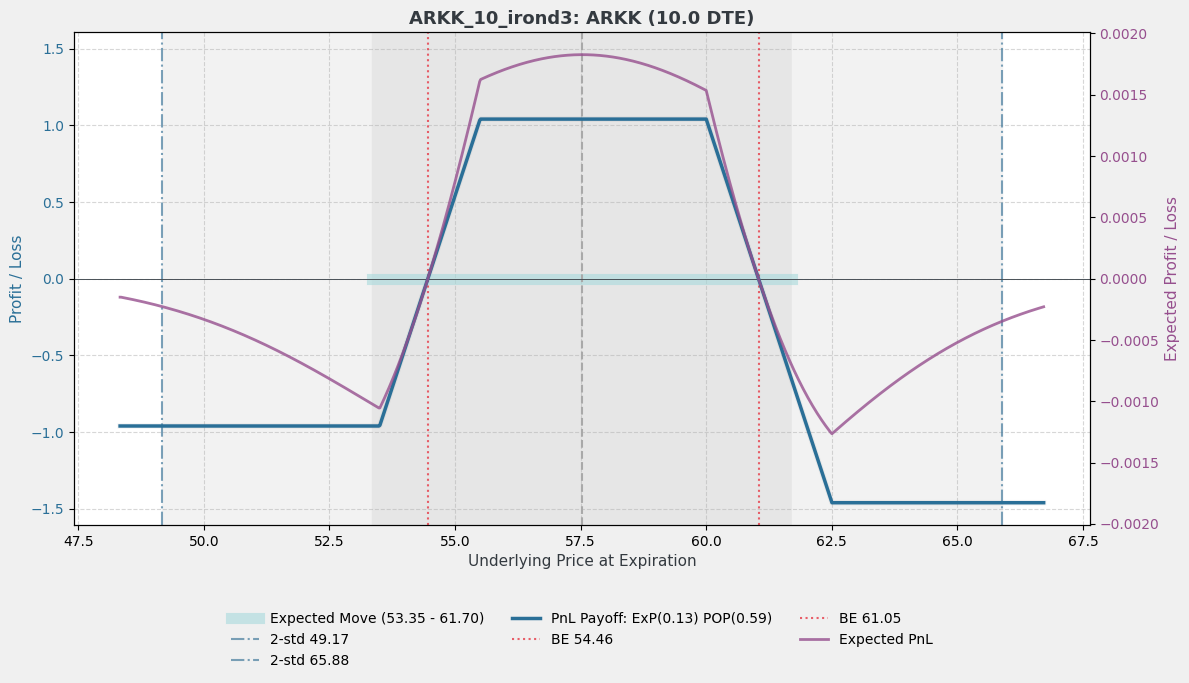


Strategy: IVV_10_buttr1
╒════════════╤══════════════════╤══════╤═════════════════════╤════════════════════╤═════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility          │ Expected Move      │ Volume ratio        │ Volatility ratio     │
├────────────┼──────────────────┼──────┼─────────────────────┼────────────────────┼─────────────────────┼──────────────────────┤
│ IVV        │ 585.855          │ 10.0 │ 0.16811728395061726 │ 16.121496841582417 │ 0.10784313725490191 │ -0.10600109609061004 │
╘════════════╧══════════════════╧══════╧═════════════════════╧════════════════════╧═════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪═══════

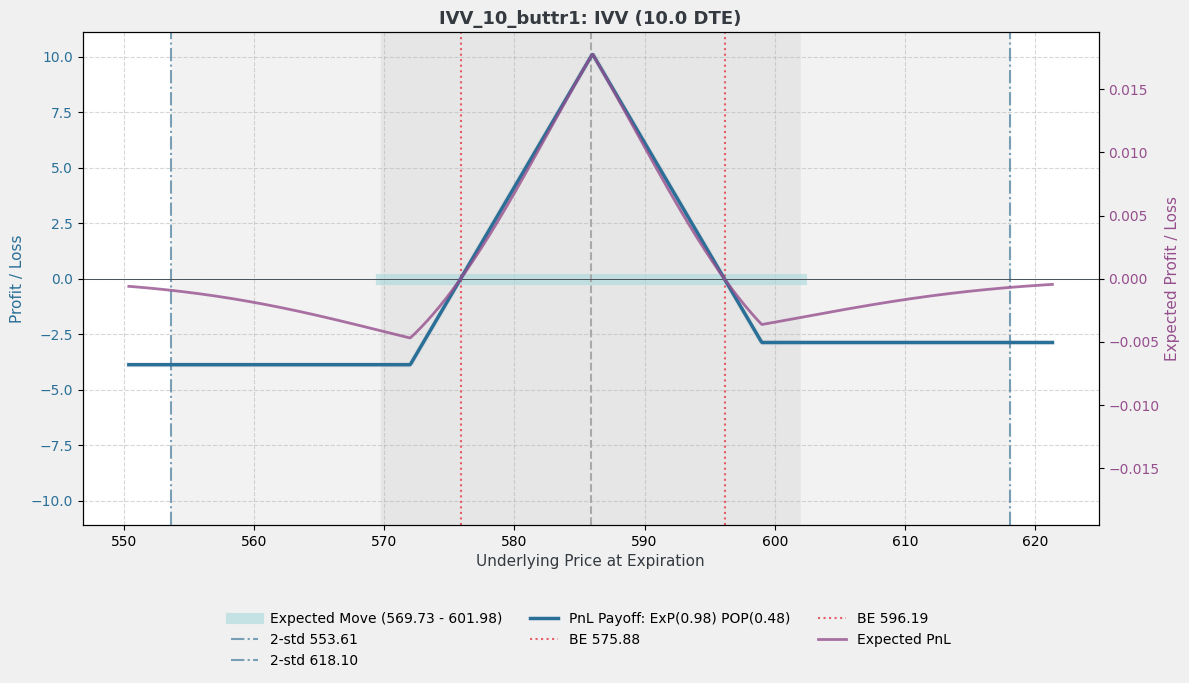


Strategy: XOP_17_csprd3
╒════════════╤══════════════════╤══════╤════════════╤══════════════════╤═══════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility │ Expected Move    │ Volume ratio      │ Volatility ratio     │
├────────────┼──────────────────┼──────┼────────────┼──────────────────┼───────────────────┼──────────────────────┤
│ XOP        │ 141.585          │ 17.0 │ 0.277725   │ 8.14315097930217 │ 0.700352526439483 │ 0.009893005000269017 │
╘════════════╧══════════════════╧══════╧════════════╧══════════════════╧═══════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪════════════╪═══════════════════╪══════════════╪════

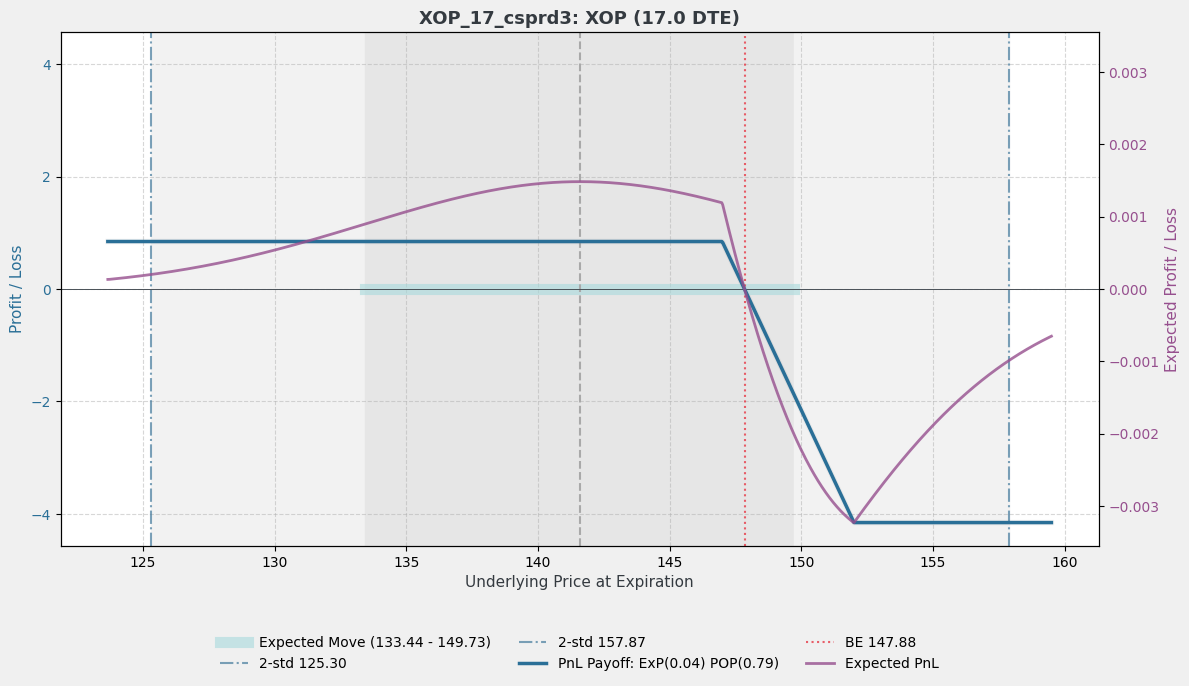


Strategy: FXE_38_buttr1
╒════════════╤══════════════════╤══════╤═════════════════════╤════════════════════╤════════════════════╤═════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility          │ Expected Move      │ Volume ratio       │ Volatility ratio    │
├────────────┼──────────────────┼──────┼─────────────────────┼────────────────────┼────────────────────┼─────────────────────┤
│ FXE        │ 94.835           │ 38.0 │ 0.08721739130434782 │ 2.6315550883131533 │ 0.5555555555555556 │ 0.04615384615384621 │
╘════════════╧══════════════════╧══════╧═════════════════════╧════════════════════╧════════════════════╧═════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪════════

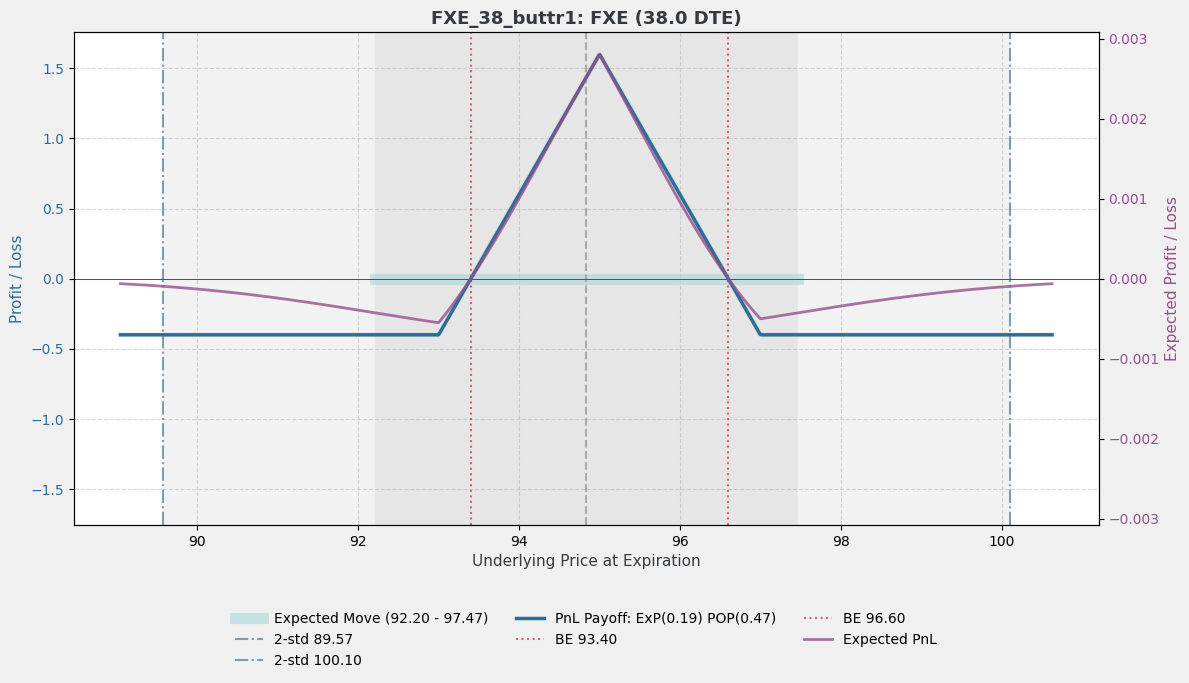


Strategy: DIS_31_csprd3
╒════════════╤══════════════════╤══════╤═════════════════════╤═══════════════════╤══════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility          │ Expected Move     │ Volume ratio         │ Volatility ratio     │
├────────────┼──────────────────┼──────┼─────────────────────┼───────────────────┼──────────────────────┼──────────────────────┤
│ DIS        │ 108.1            │ 31.0 │ 0.33841666666666664 │ 10.85298830160306 │ -0.10389610389610393 │ 0.019048774569279336 │
╘════════════╧══════════════════╧══════╧═════════════════════╧═══════════════════╧══════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪═══════

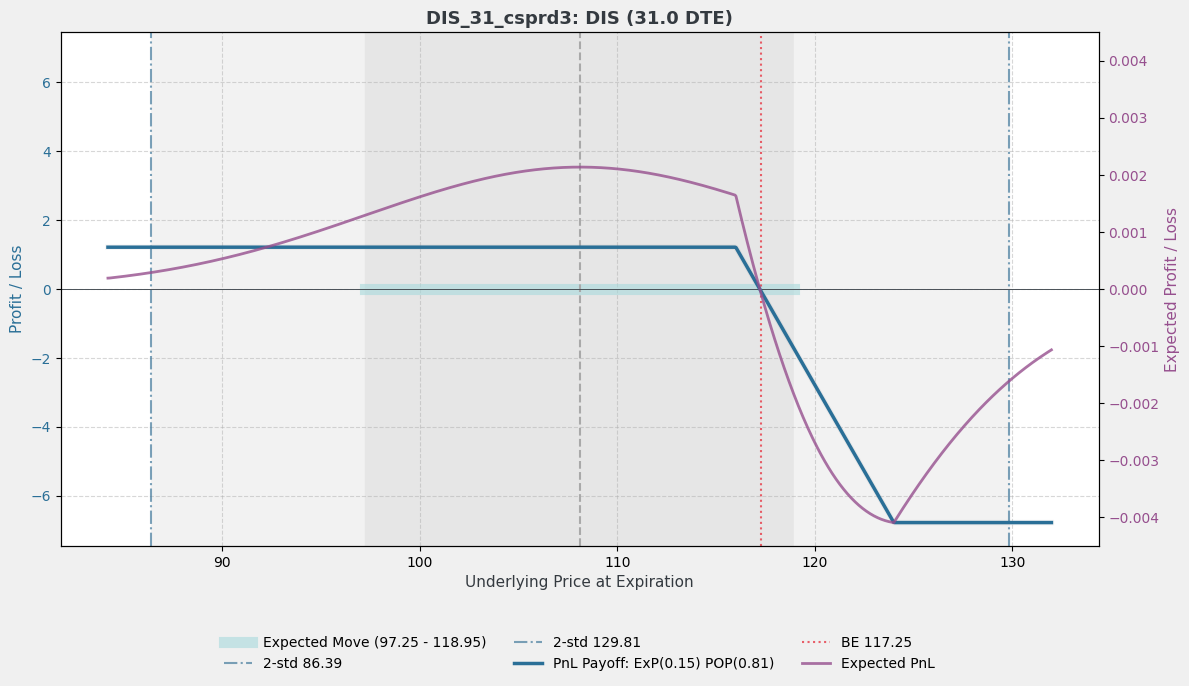


Strategy: XLU_10_csprd3
╒════════════╤══════════════════╤══════╤═════════════════════╤═══════════════════╤════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility          │ Expected Move     │ Volume ratio       │ Volatility ratio     │
├────────────┼──────────────────┼──────┼─────────────────────┼───────────────────┼────────────────────┼──────────────────────┤
│ XLU        │ 75.405           │ 10.0 │ 0.21264999999999998 │ 2.327729701721296 │ 0.5674486803519061 │ -0.07465135356849861 │
╘════════════╧══════════════════╧══════╧═════════════════════╧═══════════════════╧════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪════════

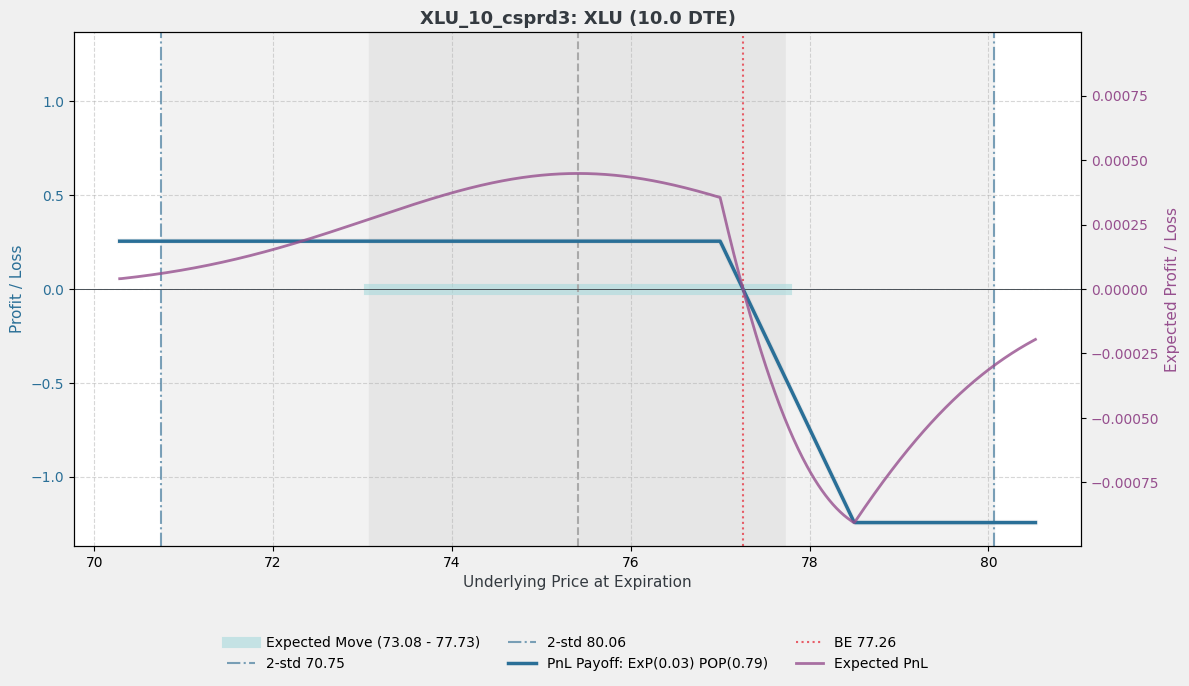


Strategy: NFLX_10_buttr1
╒════════════╤══════════════════╤══════╤════════════════════╤══════════════════╤════════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move    │ Volume ratio           │ Volatility ratio     │
├────────────┼──────────────────┼──────┼────────────────────┼──────────────────┼────────────────────────┼──────────────────────┤
│ NFLX       │ 835.85           │ 10.0 │ 0.6650238095238097 │ 92.0379205235419 │ -0.0004907975460122227 │ 0.010114803014211415 │
╘════════════╧══════════════════╧══════╧════════════════════╧══════════════════╧════════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪══════

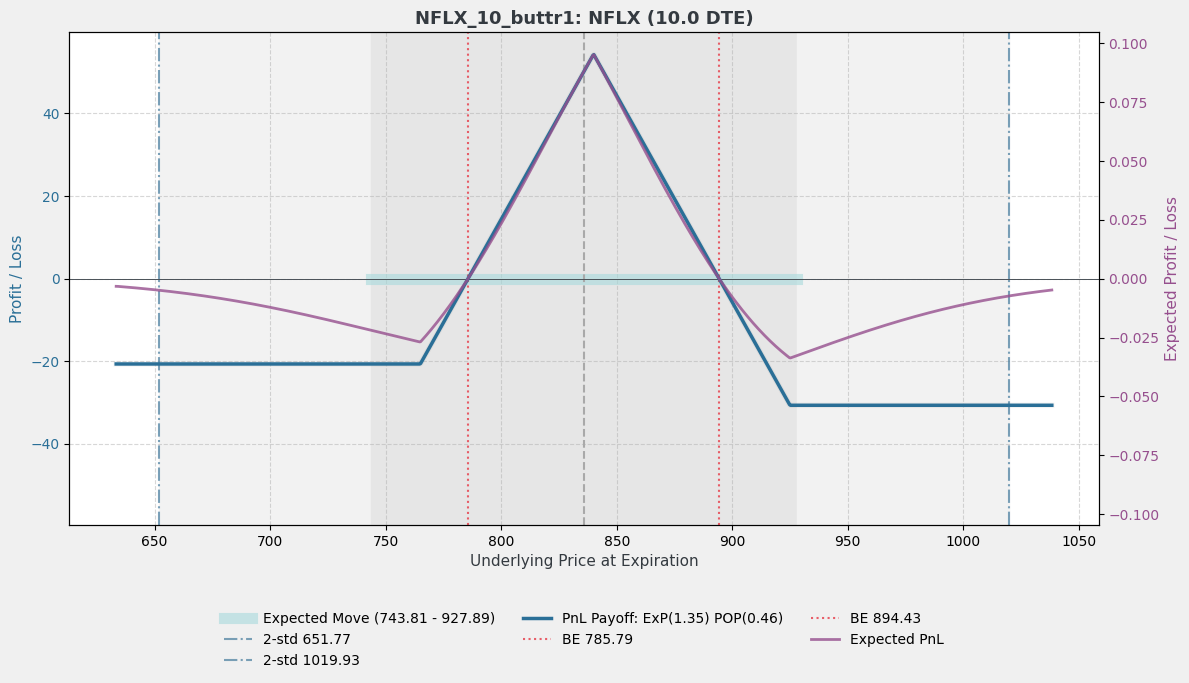


Strategy: SPX_7_csprd3
╒════════════╤══════════════════╤═════╤════════════════════╤═══════════════════╤═════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE │ Volatility         │ Expected Move     │ Volume ratio        │ Volatility ratio     │
├────────────┼──────────────────┼─────┼────────────────────┼───────────────────┼─────────────────────┼──────────────────────┤
│ SPX        │ 5851.765         │ 7.0 │ 0.1807878787878788 │ 109.8066797896723 │ -0.5910052081293808 │ -0.19138085481911138 │
╘════════════╧══════════════════╧═════╧════════════════════╧═══════════════════╧═════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days             │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪═════

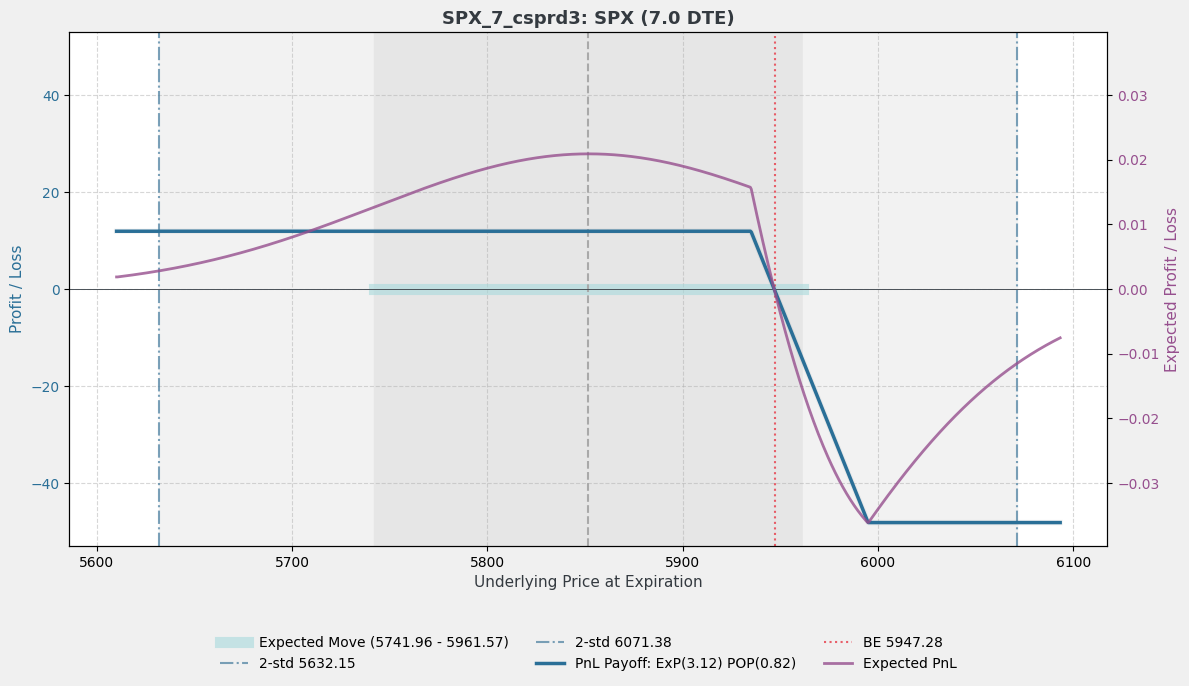


Strategy: F_31_buttr1
╒════════════╤══════════════════╤══════╤═════════════════════╤═══════════════════╤═════════════════════╤═══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility          │ Expected Move     │ Volume ratio        │ Volatility ratio      │
├────────────┼──────────────────┼──────┼─────────────────────┼───────────────────┼─────────────────────┼───────────────────────┤
│ F          │ 9.715            │ 31.0 │ 0.40437500000000004 │ 1.152316097401616 │ 0.33470733718054413 │ 0.0023809523809523725 │
╘════════════╧══════════════════╧══════╧═════════════════════╧═══════════════════╧═════════════════════╧═══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪

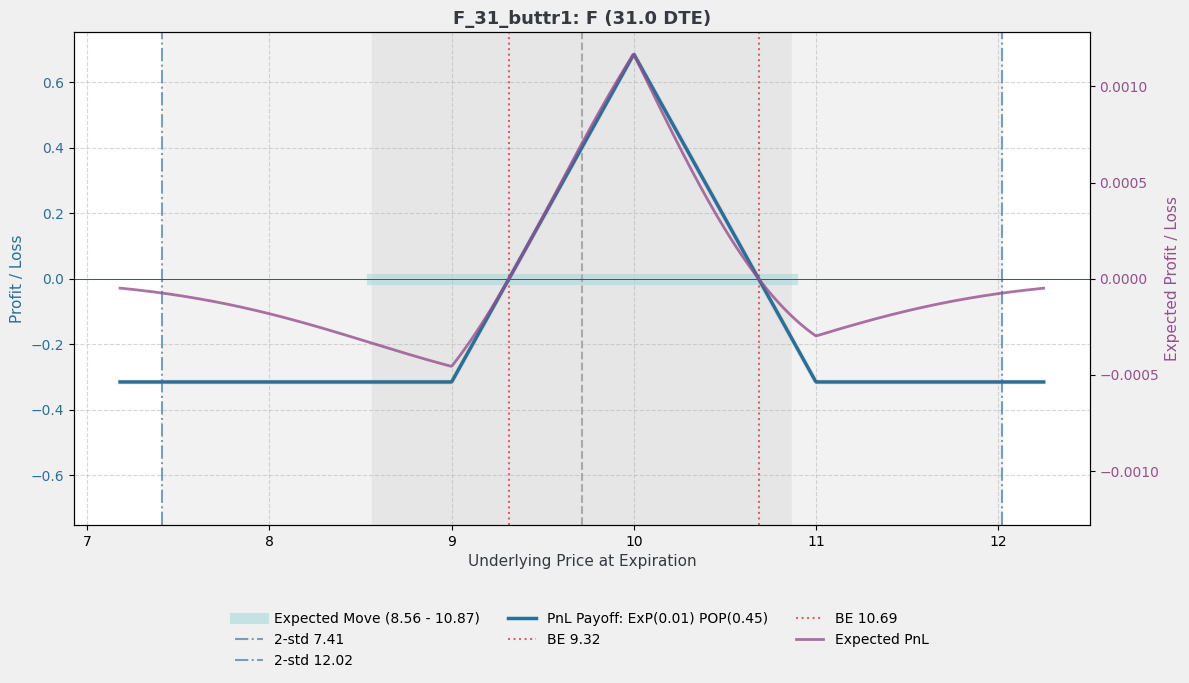


Strategy: XLI_10_buttr1
╒════════════╤══════════════════╤══════╤═════════════════════╤═══════════════════╤═════════════════════╤═════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility          │ Expected Move     │ Volume ratio        │ Volatility ratio    │
├────────────┼──────────────────┼──────┼─────────────────────┼───────────────────┼─────────────────────┼─────────────────────┤
│ XLI        │ 134.345          │ 10.0 │ 0.20422727272727273 │ 3.819194895132194 │ -0.5130293159609121 │ -0.1161684782608694 │
╘════════════╧══════════════════╧══════╧═════════════════════╧═══════════════════╧═════════════════════╧═════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪════════

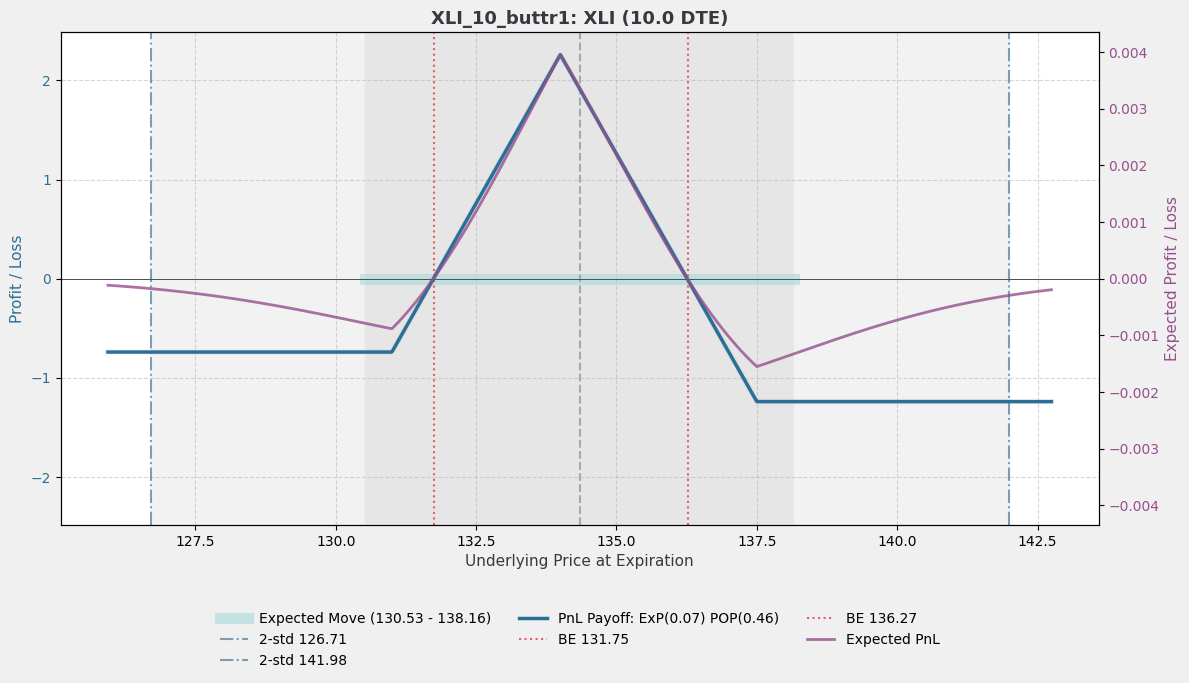


Strategy: ORCL_17_irond3
╒════════════╤══════════════════╤══════╤═════════════════════╤════════════════════╤═════════════════════╤════════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility          │ Expected Move      │ Volume ratio        │ Volatility ratio       │
├────────────┼──────────────────┼──────┼─────────────────────┼────────────────────┼─────────────────────┼────────────────────────┤
│ ORCL       │ 156.11           │ 17.0 │ 0.31513888888888886 │ 10.317746409992749 │ -0.5046473482777474 │ -0.0039525691699606735 │
╘════════════╧══════════════════╧══════╧═════════════════════╧════════════════════╧═════════════════════╧════════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞════════════════════

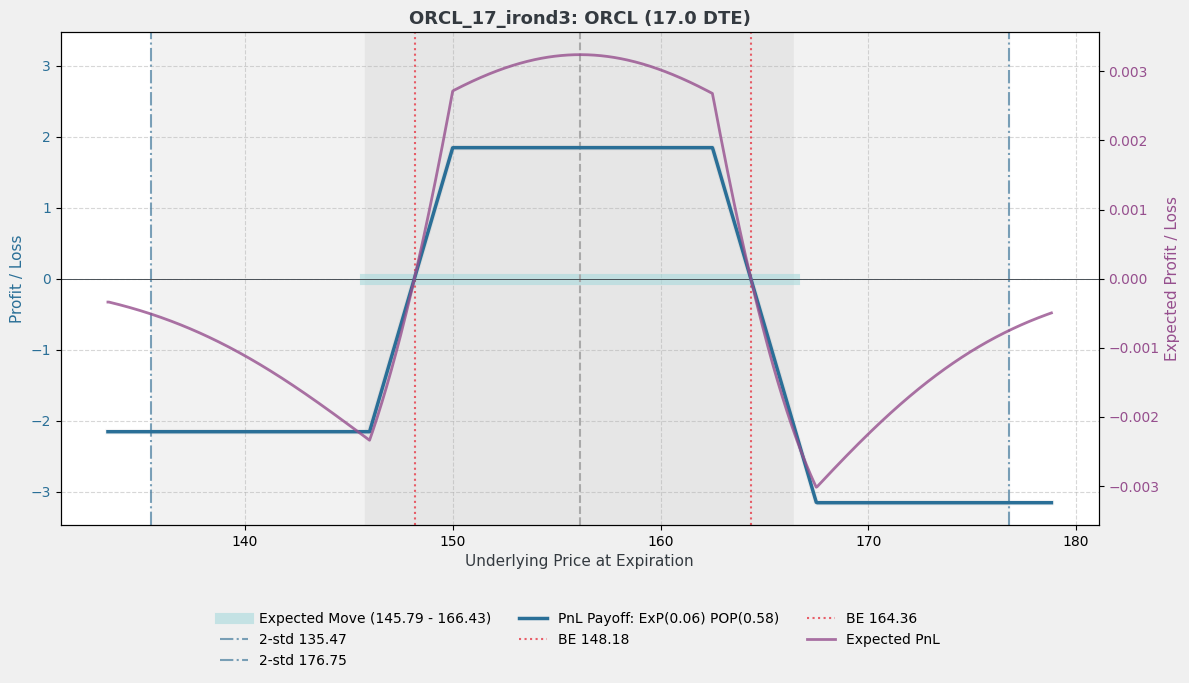


Strategy: ROKU_45_csprd3
╒════════════╤══════════════════╤══════╤════════════════════╤═══════════════════╤════════════════════╤═════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move     │ Volume ratio       │ Volatility ratio    │
├────────────┼──────────────────┼──────┼────────────────────┼───────────────────┼────────────────────┼─────────────────────┤
│ ROKU       │ 76.605           │ 45.0 │ 0.6913611111111111 │ 19.43366862297989 │ 0.5471698113207547 │ 0.04350916198164856 │
╘════════════╧══════════════════╧══════╧════════════════════╧═══════════════════╧════════════════════╧═════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪══════

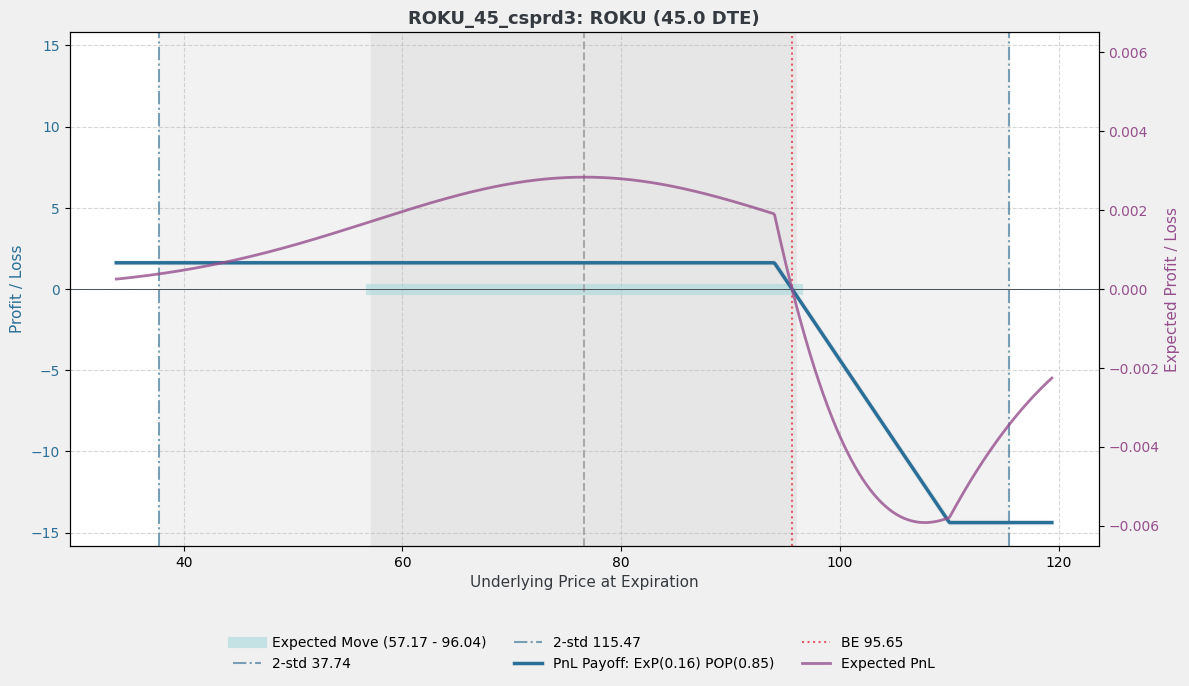


Strategy: SMCI_24_csprd3
╒════════════╤══════════════════╤══════╤════════════════════╤═══════════════════╤════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move     │ Volume ratio       │ Volatility ratio     │
├────────────┼──────────────────┼──────┼────────────────────┼───────────────────┼────────────────────┼──────────────────────┤
│ SMCI       │ 31.03            │ 24.0 │ 1.1134285714285714 │ 9.440798030718199 │ 0.3112074716477652 │ 0.012100259291270676 │
╘════════════╧══════════════════╧══════╧════════════════════╧═══════════════════╧════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪═

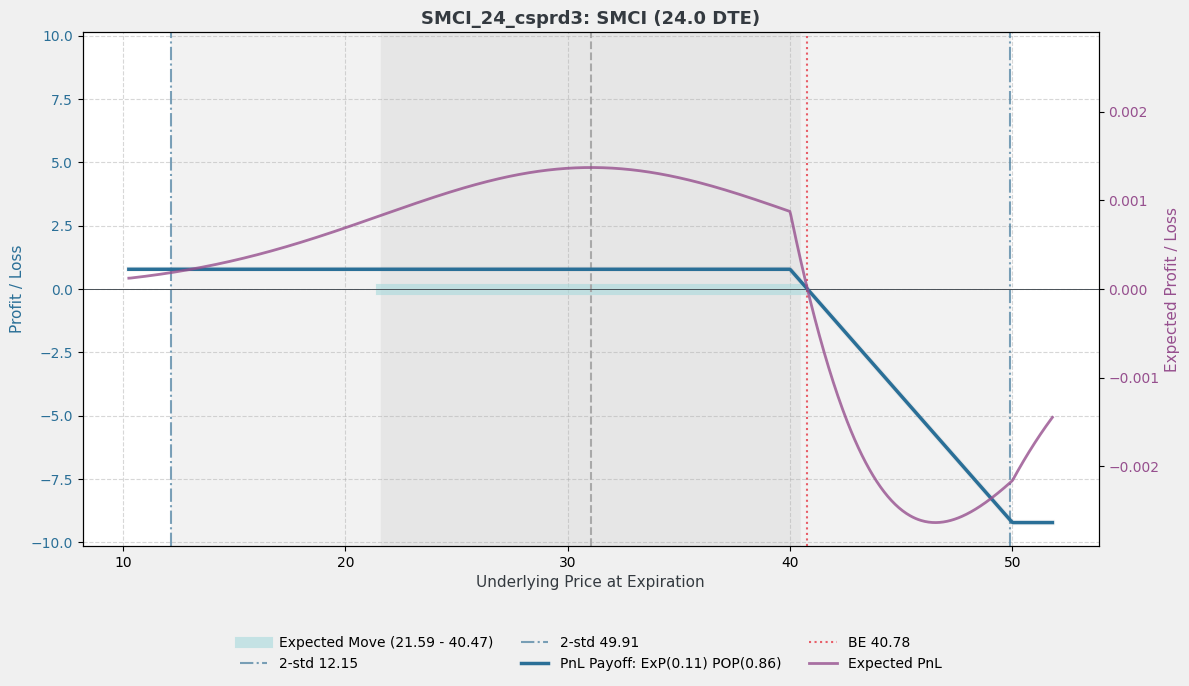


Strategy: CAT_10_csprd3
╒════════════╤══════════════════╤══════╤════════════════════╤═══════════════════╤═══════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move     │ Volume ratio      │ Volatility ratio     │
├────────────┼──────────────────┼──────┼────────────────────┼───────────────────┼───────────────────┼──────────────────────┤
│ CAT        │ 369.07           │ 10.0 │ 0.3049714285714286 │ 14.84460295789473 │ 0.360392506690455 │ -0.14539007092198597 │
╘════════════╧══════════════════╧══════╧════════════════════╧═══════════════════╧═══════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪═══════

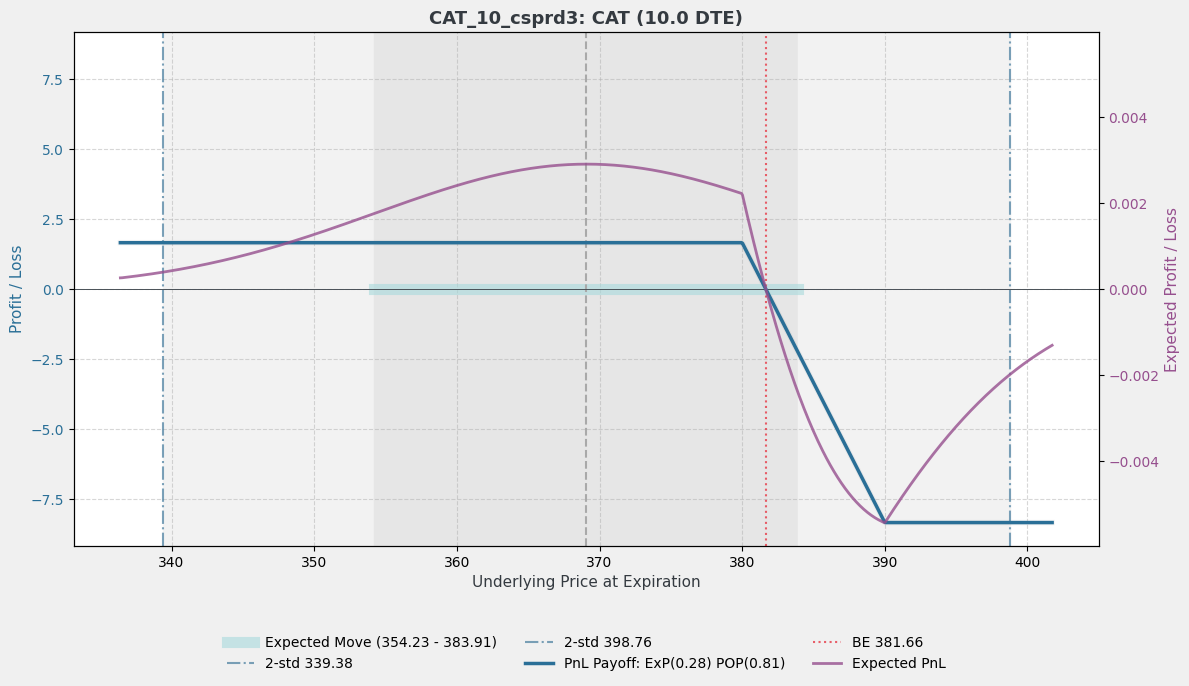


Strategy: MSTR_10_stgle3
╒════════════╤══════════════════╤══════╤════════════════════╤════════════════════╤══════════════════════╤═════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move      │ Volume ratio         │ Volatility ratio    │
├────────────┼──────────────────┼──────┼────────────────────┼────────────────────┼──────────────────────┼─────────────────────┤
│ MSTR       │ 338.345          │ 10.0 │ 0.9592968749999999 │ 56.759306924657395 │ -0.32512905224034694 │ 0.06347927547505283 │
╘════════════╧══════════════════╧══════╧════════════════════╧════════════════════╧══════════════════════╧═════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══

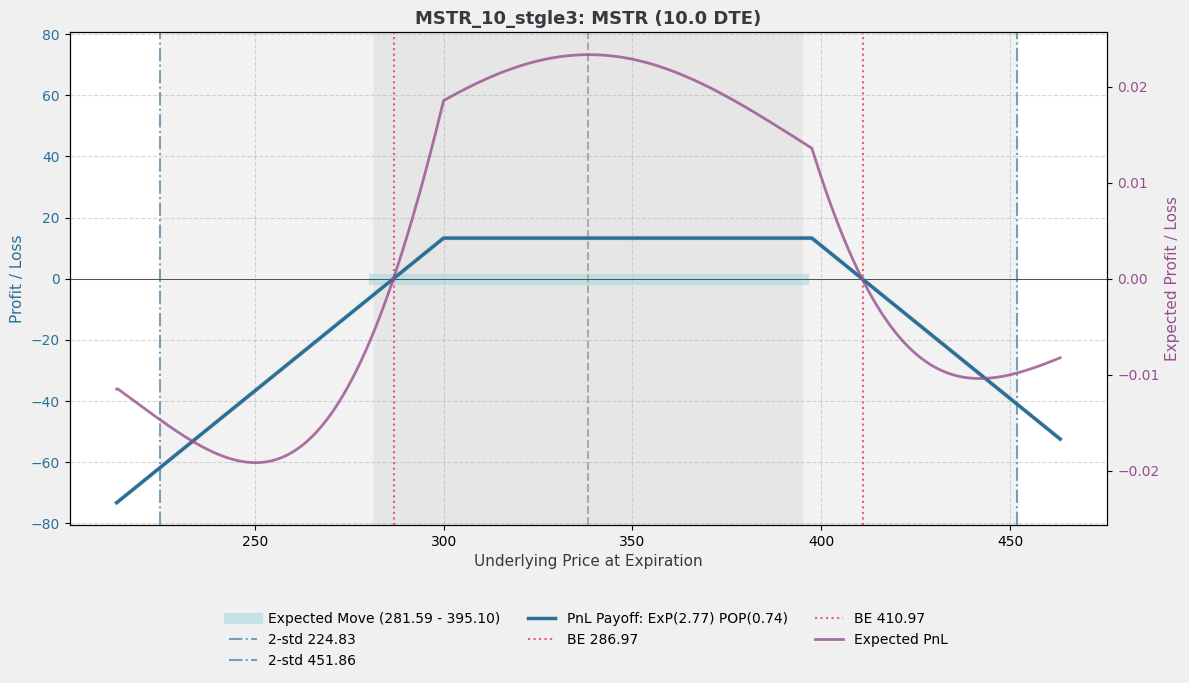


Strategy: DELL_31_irond3
╒════════════╤══════════════════╤══════╤═════════════════════╤════════════════════╤═════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility          │ Expected Move      │ Volume ratio        │ Volatility ratio     │
├────────────┼──────────────────┼──────┼─────────────────────┼────────────────────┼─────────────────────┼──────────────────────┤
│ DELL       │ 110.02           │ 31.0 │ 0.41323913043478255 │ 13.274140081501178 │ -0.6757230499561788 │ -0.03897644467039474 │
╘════════════╧══════════════════╧══════╧═════════════════════╧════════════════════╧═════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪══════

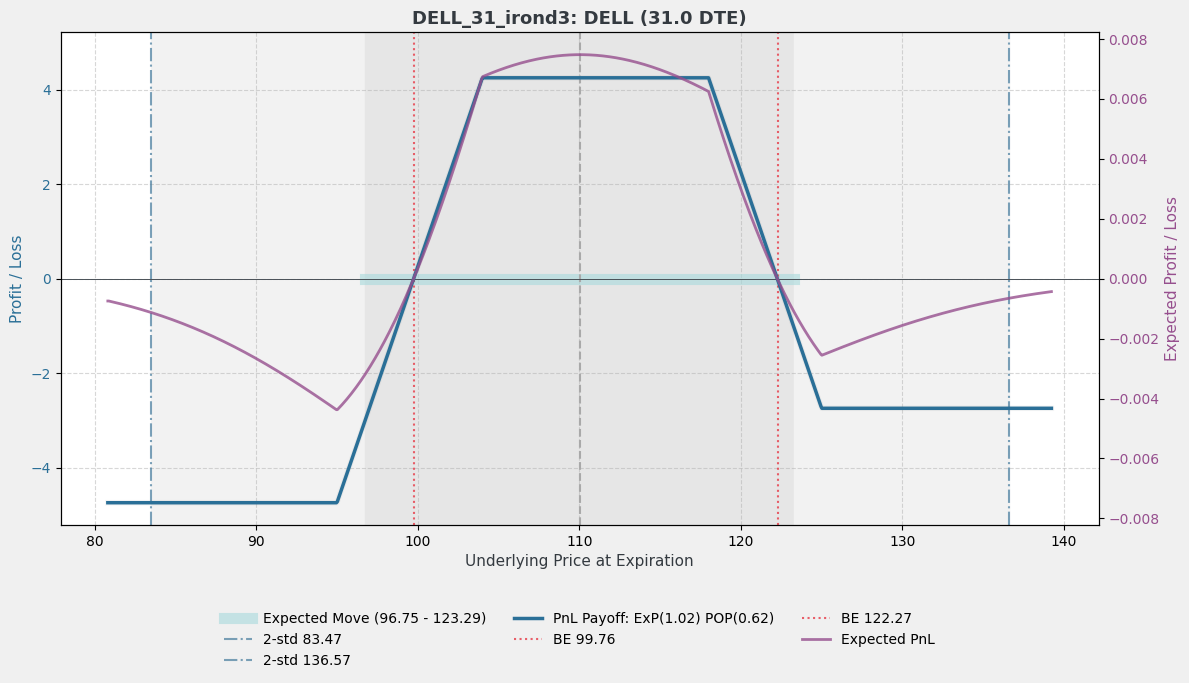


Strategy: TGT_10_csprd3
╒════════════╤══════════════════╤══════╤════════════════════╤═══════════════════╤════════════════════╤═══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move     │ Volume ratio       │ Volatility ratio      │
├────────────┼──────────────────┼──────┼────────────────────┼───────────────────┼────────────────────┼───────────────────────┤
│ TGT        │ 138.7            │ 10.0 │ 0.2985166666666667 │ 6.152687009754356 │ 0.8811093430325074 │ 0.0005330490405114352 │
╘════════════╧══════════════════╧══════╧════════════════════╧═══════════════════╧════════════════════╧═══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪════════

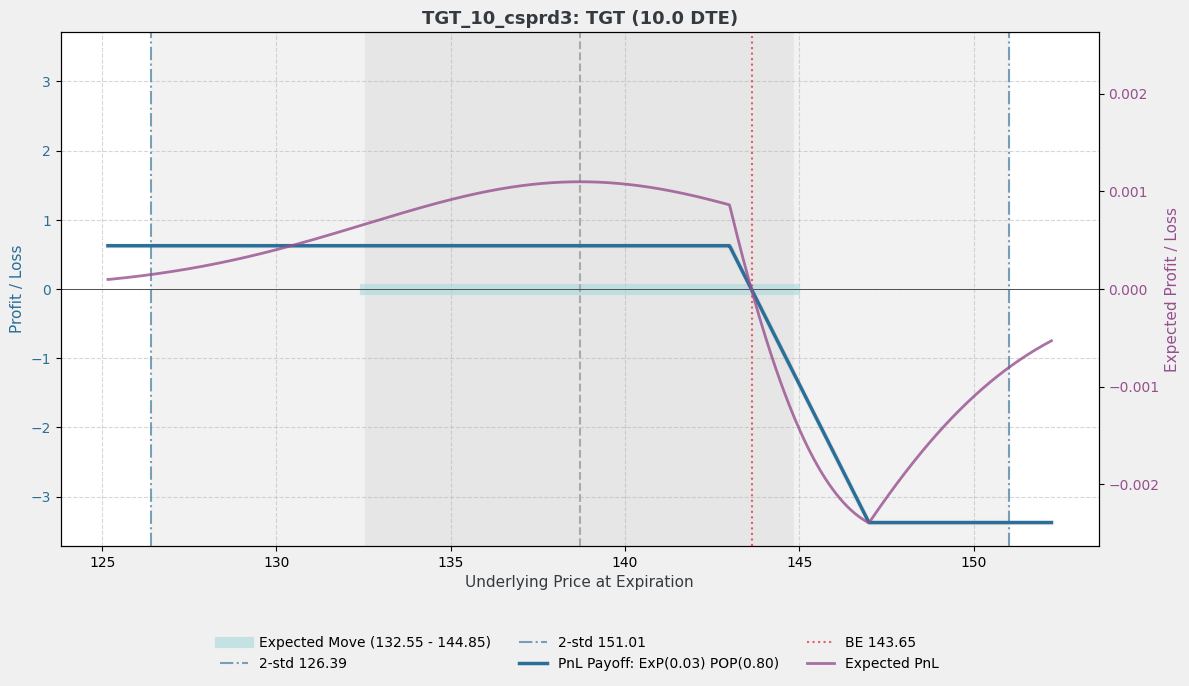


Strategy: AVGO_10_buttr1
╒════════════╤══════════════════╤══════╤════════════════════╤════════════════════╤═════════════════════╤═══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move      │ Volume ratio        │ Volatility ratio      │
├────────────┼──────────────────┼──────┼────────────────────┼────────────────────┼─────────────────────┼───────────────────────┤
│ AVGO       │ 227.49           │ 10.0 │ 0.3936666666666667 │ 14.478121690697943 │ 0.30023828435266087 │ -0.011411484713492515 │
╘════════════╧══════════════════╧══════╧════════════════════╧════════════════════╧═════════════════════╧═══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪══════

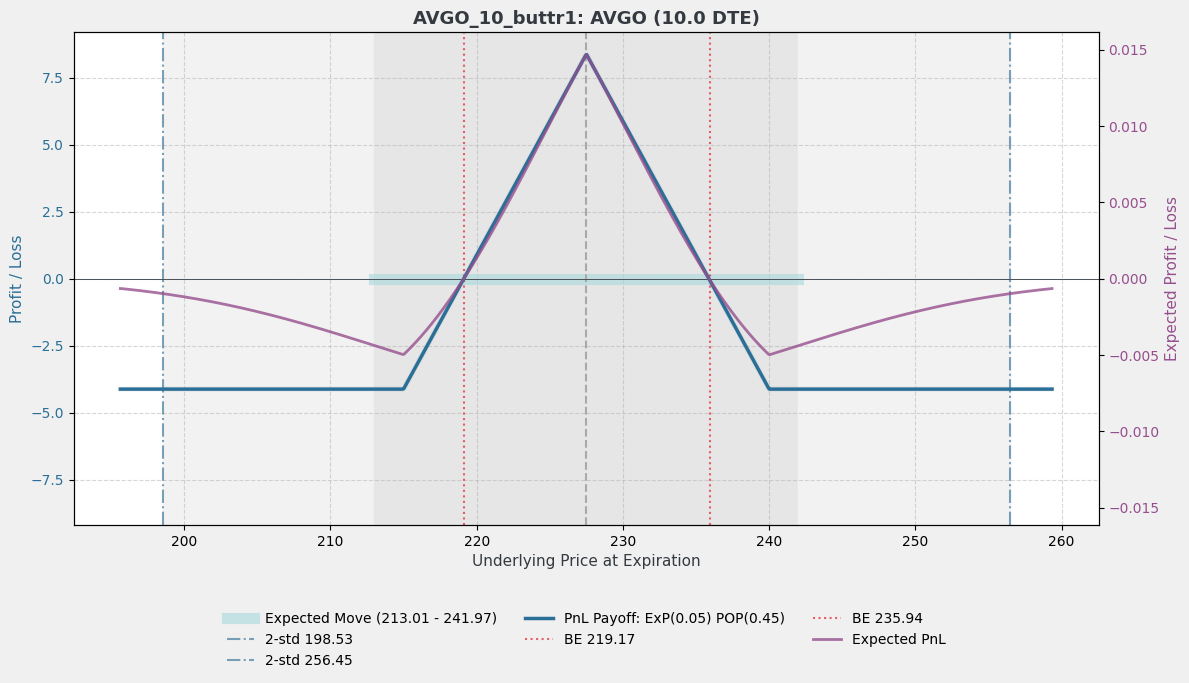


Strategy: CPB_10_csprd3
╒════════════╤══════════════════╤══════╤═════════════════════╤════════════════════╤══════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility          │ Expected Move      │ Volume ratio │ Volatility ratio     │
├────────────┼──────────────────┼──────┼─────────────────────┼────────────────────┼──────────────┼──────────────────────┤
│ CPB        │ 38.7             │ 10.0 │ 0.28222222222222215 │ 1.5725918813455615 │ 0.625        │ 0.026104417670682722 │
╘════════════╧══════════════════╧══════╧═════════════════════╧════════════════════╧══════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪════════════╪═════════

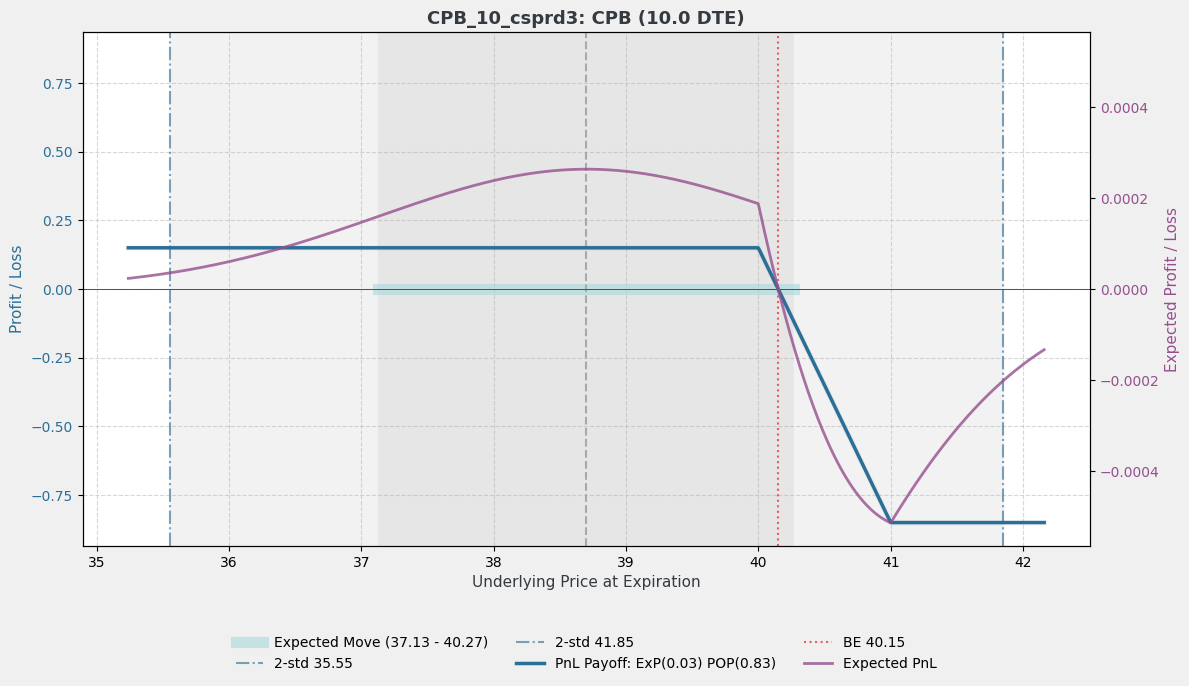


Strategy: NTAP_10_irond3
╒════════════╤══════════════════╤══════╤═════════════════════╤═══════════════════╤════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility          │ Expected Move     │ Volume ratio       │ Volatility ratio     │
├────────────┼──────────────────┼──────┼─────────────────────┼───────────────────┼────────────────────┼──────────────────────┤
│ NTAP       │ 117.25           │ 10.0 │ 0.30799999999999994 │ 5.288505078905207 │ 0.6580645161290323 │ 0.025903614457831292 │
╘════════════╧══════════════════╧══════╧═════════════════════╧═══════════════════╧════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪═══════

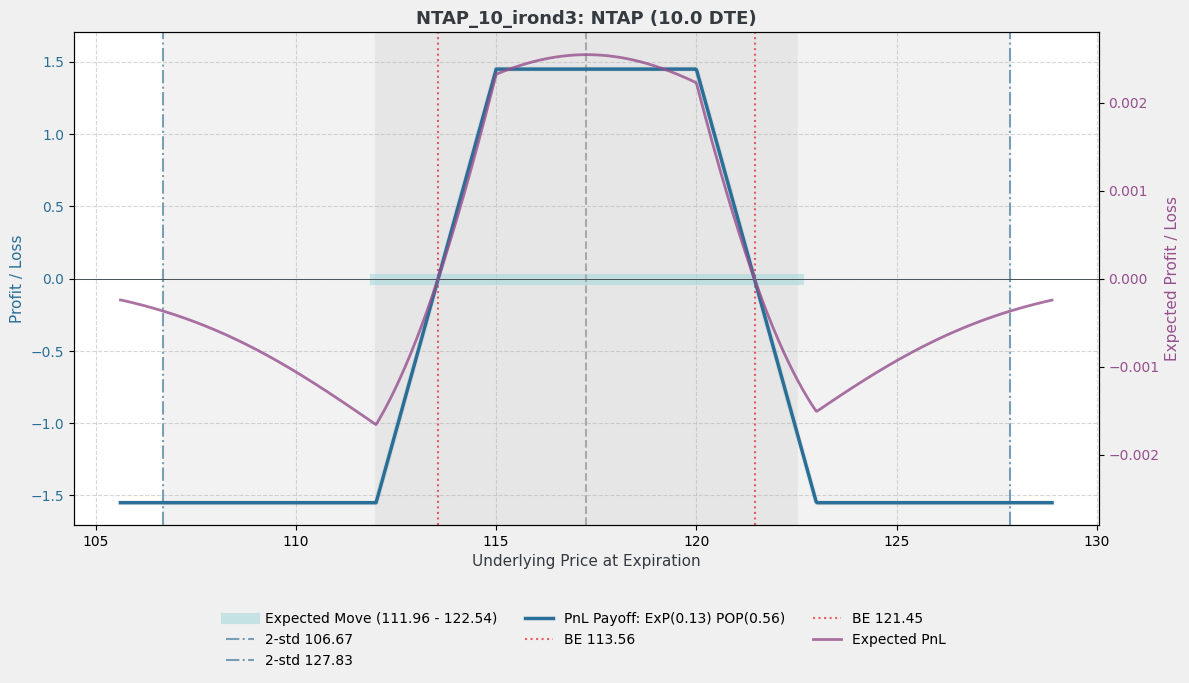


Strategy: SMH_10_csprd3
╒════════════╤══════════════════╤══════╤════════════════════╤════════════════════╤═════════════════════╤══════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move      │ Volume ratio        │ Volatility ratio     │
├────────────┼──────────────────┼──────┼────────────────────┼────────────────────┼─────────────────────┼──────────────────────┤
│ SMH        │ 245.4            │ 10.0 │ 0.3589565217391305 │ 13.424545462665696 │ -0.1832146871487449 │ -0.09740555302685483 │
╘════════════╧══════════════════╧══════╧════════════════════╧════════════════════╧═════════════════════╧══════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪═══

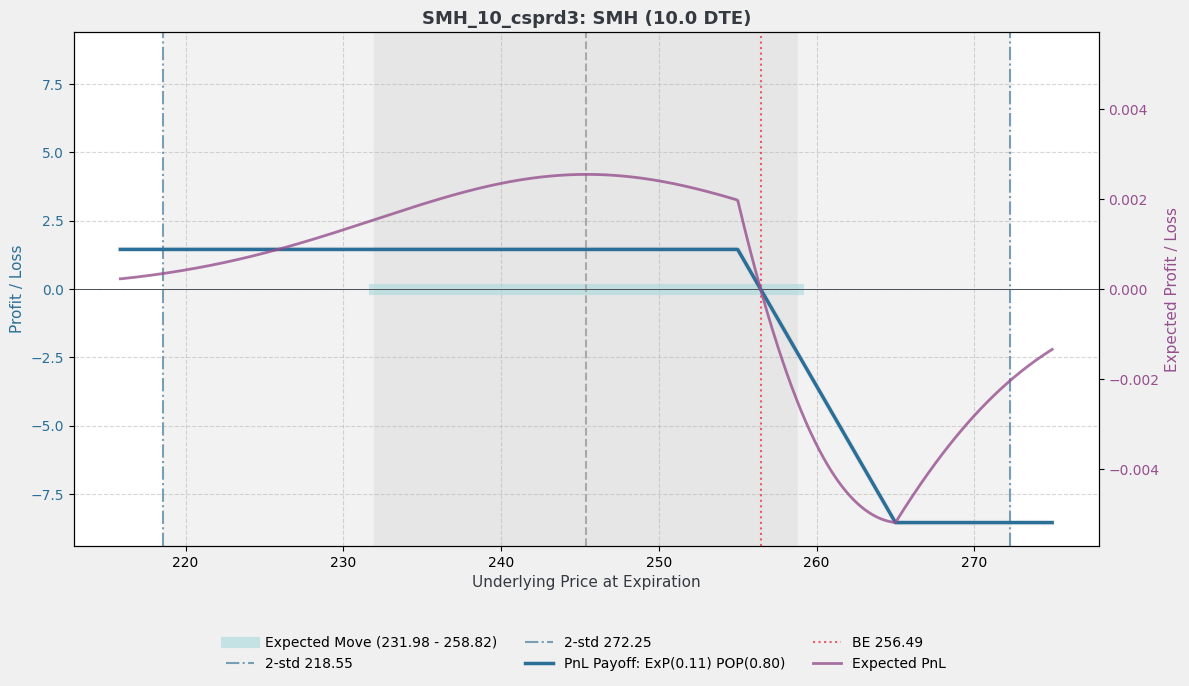


Strategy: MO_31_irond3
╒════════════╤══════════════════╤══════╤════════════════════╤════════════════════╤════════════════════╤═════════════════════╕
│ Underlying │ Underlying Price │ DTE  │ Volatility         │ Expected Move      │ Volume ratio       │ Volatility ratio    │
├────────────┼──────────────────┼──────┼────────────────────┼────────────────────┼────────────────────┼─────────────────────┤
│ MO         │ 50.915           │ 31.0 │ 0.2243846153846154 │ 3.2347197218077146 │ -0.700990099009901 │ 0.03374578177727783 │
╘════════════╧══════════════════╧══════╧════════════════════╧════════════════════╧════════════════════╧═════════════════════╛

Option Legs:
╒═══════════════════════╤════════╤══════════╤════════════╤═══════════════════╤══════════════╤════════╤═════════╤════════╤═════════╤═════════╕
│ Leg                   │ Type   │   Strike │   Quantity │ Days              │   Volatility │   Mark │   Delta │   Vega │   Theta │   Gamma │
╞═══════════════════════╪════════╪══════════╪═══

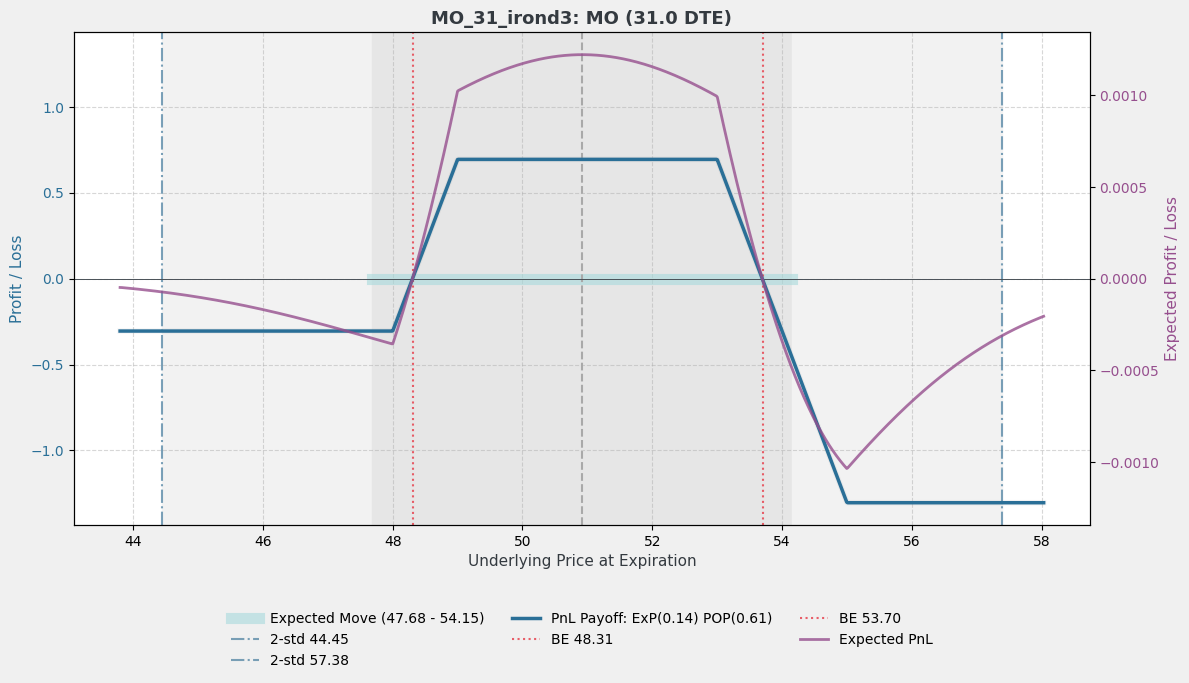

In [6]:
#################################################

# Some things I dont want to see
skip_syms: list = "HYG FXI EWZ XLF".split()

# chart and report on a sample for each symbol
for sym in syms:
    if sym in skip_syms:
        continue
    symstrats = profitable_strategies.loc[profitable_strategies['underlying_symbol'] == sym].head(1)
    for i in range(len(symstrats)):
        strat = symstrats.iloc[i].to_dict()
        show_strategy(strat)


